Datasets protein results downloaded and in: /public/compomics2/Tine/massive.ucsd.edu/v08/MSV000095036/search/DB Search Results   
Every folder contains the results from a cancer subtype, in the folder you have more subfolders that contain a protein./tsv file which is the result file  
It still needs to be filtered: 
- drop all proteinID starting with QC or rev
- use the intensity for quant


In [9]:
import os
import sys
import mlmarker
from gprofiler import GProfiler
import sys
import mlmarker
#from mlmarker.model import MLMarker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None

import tqdm
import plotly.express as px

In [ ]:
def filter_dataframe(df):
    df['PEP'] = 1 - df['Protein Probability']
    df = df.sort_values(by='PEP', ascending=True)
    df['q-value'] = df['PEP'].expanding().mean()

    df['isDecoy'] = df['Protein'].str.contains('rev_')
    fdr = (df[df['q-value'] <= 0.001].isDecoy.value_counts()[True] / df[df['q-value'] <= 0.001].shape[0])*100
    filtered_df = df[df['q-value'] <= 0.001]
    print(f"FDR: {fdr}")
    return filtered_df

In [8]:
cancers = ['CRC', 'DLBCL', 'Glioma', 'HELA', 'Melanoma', 'PDAC', 'OSCC']
cohort_map = {'CRC': 'colorectal cancer', 'DLBCL': 'diffuse large B-cell lymphoma', 'Glioma': 'Glioblastoma', 'HELA': 'HELA cervical cancer', 'Melanoma': 'melanoma', 'PDAC': 'pancreatic ductal adenocarcinoma', 'OSCC': 'oral squamous cell carcinoma'}

# The entire dataset, don't forge tthat this has no mapping

In [3]:
df = pd.read_csv('/public/compomics2/Tine/search__Picked_Group_FDR_Outputs__Picked_Group_FDR_Outputs_-_FP_Booster__combined_protein.tsv', sep='\t')
df.head()

Columns (7150) have mixed types. Specify dtype option on import or set low_memory=False.


Protein                                      Protein group  \
0   sp|P25789|PSA4_HUMAN                               sp|P25789|PSA4_HUMAN   
1  sp|P0CW01|TSPYA_HUMAN  sp|P0CW01|TSPYA_HUMAN;sp|P0CV99|TSPY4_HUMAN;sp...   
2   sp|Q9P2J5|SYLC_HUMAN                               sp|Q9P2J5|SYLC_HUMAN   
3  sp|Q8TBX8|PI42C_HUMAN                              sp|Q8TBX8|PI42C_HUMAN   
4   sp|P16233|LIPP_HUMAN                               sp|P16233|LIPP_HUMAN   

  Protein ID   Entry Name     Gene  Protein Length              Organism  \
0     P25789   PSA4_HUMAN    PSMA4             261  Homo sapiens OX=9606   
1     P0CW01  TSPYA_HUMAN   TSPY10             308  Homo sapiens OX=9606   
2     Q9P2J5   SYLC_HUMAN    LARS1            1176  Homo sapiens OX=9606   
3     Q8TBX8  PI42C_HUMAN  PIP4K2C             421  Homo sapiens OX=9606   
4     P16233   LIPP_HUMAN    PNLIP             465  Homo sapiens OX=9606   

   Protein Existence                                        Description  \
0                1.0                    Proteasome subunit alpha type-4   
1                1.0               Testis-specific Y-encoded protein 10   
2                1.0                  Leucine--tRNA ligase, cytoplasmic   
3                1.0  Phosphatidylinositol 5-phosphate 4-kinase type...   
4                1.0                  Pancreatic triacylglycerol lipase   

   Protein Probability  ...  P053267_197 MaxLFQ Intensity  \
0                0.998  ...                   799790000.0   
1                0.998  ...                           0.0   
2                0.998  ...                   803930000.0   
3                0.998  ...                   256970000.0   
4                0.998  ...                   182570000.0   

   P053268_198 MaxLFQ Intensity  P053269_199 MaxLFQ Intensity  \
0                   807780000.0                  1.010500e+09   
1                           0.0                  0.000000e+00   
2                   638150000.0                  9.179800e+08   
3                   223220000.0                  9.064600e+07   
4                           0.0                  4.871500e+08   

   P053270_200 MaxLFQ Intensity  P053271_201 MaxLFQ Intensity  \
0                  6.425800e+08                   691190000.0   
1                  0.000000e+00                           0.0   
2                  1.215100e+09                   821700000.0   
3                  1.447000e+08                   114920000.0   
4                  0.000000e+00                   546690000.0   

   P053272_202 MaxLFQ Intensity  P053273_203 MaxLFQ Intensity  \
0                  9.060200e+08                   755740000.0   
1                  0.000000e+00                           0.0   
2                  1.114800e+09                   818560000.0   
3                  2.058400e+08                   139050000.0   
4                  0.000000e+00                   288120000.0   

   P053274_204 MaxLFQ Intensity  P053275_205 MaxLFQ Intensity  \
0                   923250000.0                  4.957100e+08   
1                           0.0                  0.000000e+00   
2                   803250000.0                  1.036600e+09   
3                   128740000.0                  7.902500e+07   
4                   369410000.0                  0.000000e+00   

                          Indistinguishable Proteins  
0                                                NaN  
1  sp|P0CV99|TSPY4_HUMAN, sp|P0CV98|TSPY3_HUMAN, ...  
2                                                NaN  
3                                                NaN  
4                                                NaN  

[5 rows x 7151 columns]

In [4]:
expression_columns = [col for col in df.columns if "MaxLFQ Intensity" in col]
len(expression_columns)

1427

In [5]:
#add 199 columns to df that have random values

expression_columns = [col for col in df.columns if "MaxLFQ Intensity" in col]
expression_values = df[expression_columns].values.flatten()

# Remove NaN values for sampling
expression_values = expression_values[~np.isnan(expression_values)]

# Function to generate random expression values resembling the original data
def generate_random_expression(size, reference_values):
    mean = np.mean(reference_values)
    std = np.std(reference_values)
    return np.random.normal(loc=mean, scale=std, size=size)

# Adding 200 new columns with random values
for i in range(1, 3):
    new_col_name = f"Random_Expression_{i}"
    df[new_col_name] = generate_random_expression(len(df), expression_values)
df["Zero_Column"] = 0

df.head()

Protein                                      Protein group  \
0   sp|P25789|PSA4_HUMAN                               sp|P25789|PSA4_HUMAN   
1  sp|P0CW01|TSPYA_HUMAN  sp|P0CW01|TSPYA_HUMAN;sp|P0CV99|TSPY4_HUMAN;sp...   
2   sp|Q9P2J5|SYLC_HUMAN                               sp|Q9P2J5|SYLC_HUMAN   
3  sp|Q8TBX8|PI42C_HUMAN                              sp|Q8TBX8|PI42C_HUMAN   
4   sp|P16233|LIPP_HUMAN                               sp|P16233|LIPP_HUMAN   

  Protein ID   Entry Name     Gene  Protein Length              Organism  \
0     P25789   PSA4_HUMAN    PSMA4             261  Homo sapiens OX=9606   
1     P0CW01  TSPYA_HUMAN   TSPY10             308  Homo sapiens OX=9606   
2     Q9P2J5   SYLC_HUMAN    LARS1            1176  Homo sapiens OX=9606   
3     Q8TBX8  PI42C_HUMAN  PIP4K2C             421  Homo sapiens OX=9606   
4     P16233   LIPP_HUMAN    PNLIP             465  Homo sapiens OX=9606   

   Protein Existence                                        Description  \
0                1.0                    Proteasome subunit alpha type-4   
1                1.0               Testis-specific Y-encoded protein 10   
2                1.0                  Leucine--tRNA ligase, cytoplasmic   
3                1.0  Phosphatidylinositol 5-phosphate 4-kinase type...   
4                1.0                  Pancreatic triacylglycerol lipase   

   Protein Probability  ...  P053270_200 MaxLFQ Intensity  \
0                0.998  ...                  6.425800e+08   
1                0.998  ...                  0.000000e+00   
2                0.998  ...                  1.215100e+09   
3                0.998  ...                  1.447000e+08   
4                0.998  ...                  0.000000e+00   

   P053271_201 MaxLFQ Intensity  P053272_202 MaxLFQ Intensity  \
0                   691190000.0                  9.060200e+08   
1                           0.0                  0.000000e+00   
2                   821700000.0                  1.114800e+09   
3                   114920000.0                  2.058400e+08   
4                   546690000.0                  0.000000e+00   

   P053273_203 MaxLFQ Intensity  P053274_204 MaxLFQ Intensity  \
0                   755740000.0                   923250000.0   
1                           0.0                           0.0   
2                   818560000.0                   803250000.0   
3                   139050000.0                   128740000.0   
4                   288120000.0                   369410000.0   

   P053275_205 MaxLFQ Intensity  \
0                  4.957100e+08   
1                  0.000000e+00   
2                  1.036600e+09   
3                  7.902500e+07   
4                  0.000000e+00   

                          Indistinguishable Proteins  Random_Expression_1  \
0                                                NaN         7.875650e+09   
1  sp|P0CV99|TSPY4_HUMAN, sp|P0CV98|TSPY3_HUMAN, ...        -2.077088e+09   
2                                                NaN        -3.121555e+09   
3                                                NaN         3.711299e+08   
4                                                NaN        -3.742047e+09   

   Random_Expression_2  Zero_Column  
0         2.387674e+09            0  
1         7.983193e+08            0  
2        -1.774003e+09            0  
3        -3.910385e+09            0  
4        -2.544130e+08            0  

[5 rows x 7154 columns]

In [11]:
filtered_df = df.filter(regex='Protein ID|MaxLFQ|Random_Expression|Zero_Column')
print(filtered_df.shape)

model = mlmarker.MLMarker(binary=False, dev=True, penalty_factor=1)


added_features_per_sample = {}
prediction_dict = {}
for c in tqdm.tqdm(filtered_df.columns[1:]):
    subset = filtered_df[["Protein ID", c]]
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    subset[c] = scaler.fit_transform(subset[[c]])
    subset_pv = subset.pivot_table(columns='Protein ID', values = c)
    subset_pv = subset_pv.loc[:, (subset_pv != 0).any(axis=0)]
    model.load_sample(subset_pv.iloc[0:1, :])
    added_features = model.load_sample(subset_pv.iloc[0:1, :], output_added_features=True)
    added_features_per_sample[c] = added_features
    prediction = model.explainability.adjusted_absent_shap_values_df(n_preds=100).T.sum(axis=0)
    prediction_dict[c] = prediction
prediction_df = pd.DataFrame(prediction_dict)
# prediction_df.to_csv(f'Entire_picked_FDR_MLMarker_predictions_dev_nopenalty.csv')

#PCA 
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# principalComponents = pca.fit_transform(prediction_df.T)
# principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
# finalDf = pd.concat([principalDf], axis = 1)
# finalDf['sample'] = prediction_df.columns
# finalDf['final_sample'] = finalDf['sample'].str.split('_').str[0]
# fig = plt.figure(figsize = (8,8))
# ax = fig.add_subplot(1,1,1)
# ax.set_xlabel('Principal Component 1', fontsize = 15)
# ax.set_ylabel('Principal Component 2', fontsize = 15)
# plt.scatter(finalDf['principal component 1'], finalDf['principal component 2'], s=50)
# plt.show()
# fig.savefig(f'Entire_picked_FDR_PCA_nopenalty.png')
# sns.clustermap(prediction_df, cmap='viridis', figsize=(10,10))
# #save the clustermap
# plt.savefig(f'Entire_picked_FDR_clustermap_nopenalty.png')


(18498, 1431)


/home/compomics/miniconda3/envs/mlmarker/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning:

Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.



KeyError: 64

In [9]:
#plot the number of added features across the entire dataset
filtered_df = df.filter(regex='Protein ID|MaxLFQ|Random_Expression|Zero_Column')
print(filtered_df.shape)

model = mlmarker.MLMarker(binary=False, dev=True, penalty_factor=1)


added_features_per_sample = {}
prediction_dict = {}
for c in tqdm.tqdm(filtered_df.columns[1:]):
    subset = filtered_df[["Protein ID", c]]
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    subset[c] = scaler.fit_transform(subset[[c]])
    subset_pv = subset.pivot_table(columns='Protein ID', values = c)
    subset_pv = subset_pv.loc[:, (subset_pv != 0).any(axis=0)]
    model.load_sample(subset_pv.iloc[0:1, :])
    added_features = model.load_sample(subset_pv.iloc[0:1, :], output_added_features=True)
    added_features_per_sample[c] = added_features


(18498, 1431)


100%|██████████| 1430/1430 [13:36<00:00,  1.75it/s]


In [12]:
added_lengths = []
for v in added_features_per_sample.values():
    added_lengths.append(len(v))

In [ ]:
with open('added_lengths.txt', 'w') as file:
    for length in added_lengths:
        file.write(str(length) + '\n')


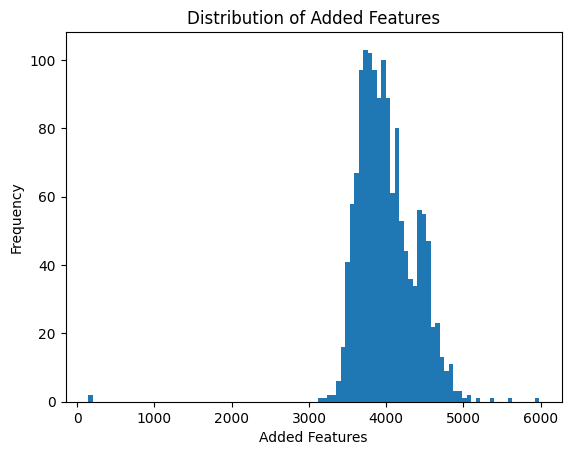

In [21]:


plt.hist(added_lengths, bins=100)
plt.xlabel('Added Features')
plt.ylabel('Frequency')
plt.title('Distribution of Added Features')
plt.show()


# Important note: the Melanoma and HELA cohort have no mapping in MLMarker!

In [ ]:
# filtered_df = df.filter(regex='Protein ID|Random_Expression|Zero_Column')
# print(filtered_df.shape)
# prediction_dict = {}
# for c in tqdm.tqdm(filtered_df.columns[1:]):
#     subset = filtered_df[["Protein ID", c]]
#     from sklearn.preprocessing import MinMaxScaler
#     scaler = MinMaxScaler()
#     subset[c] = scaler.fit_transform(subset[[c]])
#     subset_pv = subset.pivot_table(columns='Protein ID', values = c)
#     test = MLMarker(subset_pv.iloc[0:1,:], binary = False, dev=True)
#     prediction = test.explainability.adjusted_absent_shap_values_df(n_preds=100, penalty_factor=0.5).T.sum(axis=0)
#     prediction_dict[c] = prediction
# random_prediction_df = pd.DataFrame(prediction_dict)


In [ ]:
prediction_df.to_csv('Entire_picked_FDR_MLMarker_predictions_dev_penalty1.csv')

In [ ]:
import json

# Convert dictionary to JSON string
added_features_json = json.dumps(added_features_per_sample)

# Write JSON string to a text file
with open('added_features_per_sample_penalty1.txt', 'w') as file:
    file.write(added_features_json)


In [6]:
prediction_df = pd.read_csv('Entire_picked_FDR_MLMarker_predictions_dev_penalty1.csv')
prediction_df.set_index('tissue', inplace=True)
prediction_df.head()

P066172_1 MaxLFQ Intensity  P066173_2 MaxLFQ Intensity  \
tissue                                                                   
Adipose tissue                    -0.02988                    -0.02907   
Adrenal gland                     -0.00513                    -0.01148   
Appendix                           0.02924                     0.00918   
B-cells                            0.06433                     0.00135   
Bone marrow                       -0.06602                    -0.06128   

                P066174_3 MaxLFQ Intensity  P066175_4 MaxLFQ Intensity  \
tissue                                                                   
Adipose tissue                    -0.02590                    -0.03079   
Adrenal gland                     -0.00632                    -0.00494   
Appendix                          -0.00731                    -0.02112   
B-cells                            0.10691                     0.05316   
Bone marrow                       -0.07057                    -0.06031   

                P066176_5 MaxLFQ Intensity  P066177_6 MaxLFQ Intensity  \
tissue                                                                   
Adipose tissue                    -0.02397                    -0.03120   
Adrenal gland                     -0.01179                    -0.00774   
Appendix                          -0.00938                     0.02487   
B-cells                            0.01478                     0.00815   
Bone marrow                       -0.06240                    -0.06870   

                P066178_7 MaxLFQ Intensity  P066179_8 MaxLFQ Intensity  \
tissue                                                                   
Adipose tissue                    -0.03484                    -0.03030   
Adrenal gland                     -0.00786                    -0.00833   
Appendix                          -0.02435                     0.01399   
B-cells                            0.04598                     0.03836   
Bone marrow                       -0.06331                    -0.05176   

                P066180_9 MaxLFQ Intensity  P066181_10 MaxLFQ Intensity  ...  \
tissue                                                                   ...   
Adipose tissue                    -0.01789                     -0.02000  ...   
Adrenal gland                      0.00060                     -0.01307  ...   
Appendix                          -0.02366                     -0.00174  ...   
B-cells                            0.01960                      0.03673  ...   
Bone marrow                       -0.06387                     -0.05634  ...   

                P053269_199 MaxLFQ Intensity  P053270_200 MaxLFQ Intensity  \
tissue                                                                       
Adipose tissue                      -0.02218                      -0.03849   
Adrenal gland                       -0.01072                      -0.00749   
Appendix                            -0.01411                      -0.01312   
B-cells                              0.02577                       0.05450   
Bone marrow                         -0.07080                      -0.06224   

                P053271_201 MaxLFQ Intensity  P053272_202 MaxLFQ Intensity  \
tissue                                                                       
Adipose tissue                      -0.02296                      -0.03480   
Adrenal gland                        0.00707                      -0.00938   
Appendix                            -0.00330                      -0.01206   
B-cells                              0.06720                       0.04397   
Bone marrow                         -0.07253                      -0.07197   

                P053273_203 MaxLFQ Intensity  P053274_204 MaxLFQ Intensity  \
tissue                                                                       
Adipose tissue                      -0.03545                      -0.03265   
Adrenal gland                       -0.00131       

In [10]:
tissues = prediction_df.index

In [11]:
model = mlmarker.MLMarker(binary=False, dev=True, penalty_factor=1)
model.get_model_classes()

Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


array(['Adipose tissue', 'Adrenal gland', 'Appendix', 'B-cells',
       'Bone marrow', 'Brain', 'Colon', 'Duodenum', 'Endometrium',
       'Esophagus', 'Heart', 'Kidney', 'Liver', 'Lung', 'Lymph node',
       'Monocytes', 'Nasal Polyps', 'Ovary', 'Oviduct', 'Parotid gland',
       'Pituitary gland', 'Placenta', 'Prostate', 'Rectum',
       'Salivary gland', 'Skeletal muscle', 'Small intestine',
       'Smooth muscle', 'Spleen', 'Stomach', 'Testis', 'Thyroid',
       'Tonsil', 'Urinary bladder'], dtype=object)

In [12]:
metadata = pd.read_csv('MassIVE_Mapping.txt', sep='\t')
prediction_mapping = prediction_df.T.reset_index()
prediction_mapping['sample'] = prediction_mapping['index'].str.split(' MaxLFQ Intensity').str[0]
prediction_mapping = prediction_mapping.merge(metadata[['Cohort', 'Folder name FP_DDA']], left_on='sample', right_on='Folder name FP_DDA').drop_duplicates()
cancer_map = {'CRC': 'Colon', 
'DLBCL': 'B-cells', 
'DLBCL+': 'B-cells',
'Glioma': 'Brain', 
'HELA': 'Hela', 
'Melanoma': 'Skin', 
'PDAC': 'Pancreas',
'OSCC': 'Parotid gland',
'healthy LN': 'Lymph node',
'healthy OE': 'Parotid gland'}
prediction_mapping.replace('DLBCL+', 'DLBCL', inplace=True)
prediction_mapping['Correct tissue'] = prediction_mapping['Cohort'].map(cancer_map)
prediction_mapping['Correct tissue'] = prediction_mapping['Correct tissue'].fillna('Other')
#predicted tissue is the highest value in the prediction_df, that column name
prediction_mapping['Cancer_type'] = prediction_mapping.Cohort.map(cohort_map)
prediction_mapping['Predicted tissue 1'] = prediction_mapping[prediction_mapping.columns[1:35]].idxmax(axis=1)
prediction_mapping['Predicted tissue 2'] = prediction_mapping[prediction_mapping.columns[1:35]].apply(lambda x: x.nlargest(2).index.tolist()[1], axis=1)
prediction_mapping['Predicted tissue 3'] = prediction_mapping[prediction_mapping.columns[1:35]].apply(lambda x: x.nlargest(3).index.tolist()[2], axis=1)
prediction_mapping['Predicted tissue 4'] = prediction_mapping[prediction_mapping.columns[1:35]].apply(lambda x: x.nlargest(4).index.tolist()[3], axis=1)
prediction_mapping['Predicted tissue 5'] = prediction_mapping[prediction_mapping.columns[1:35]].apply(lambda x: x.nlargest(5).index.tolist()[4], axis=1)
# prediction_mapping['added_features'] = prediction_mapping['index'].map(lambda x: len(added_features_per_sample[x]))
prediction_mapping['Predicted tissue 1'].value_counts()




Predicted tissue 1
B-cells            595
Brain              228
Tonsil             223
Parotid gland      165
Nasal Polyps       137
Skeletal muscle     19
Ovary               12
Colon               12
Stomach              8
Liver                7
Duodenum             7
Testis               5
Pituitary gland      2
Lymph node           2
Monocytes            1
Kidney               1
Thyroid              1
Small intestine      1
Name: count, dtype: int64

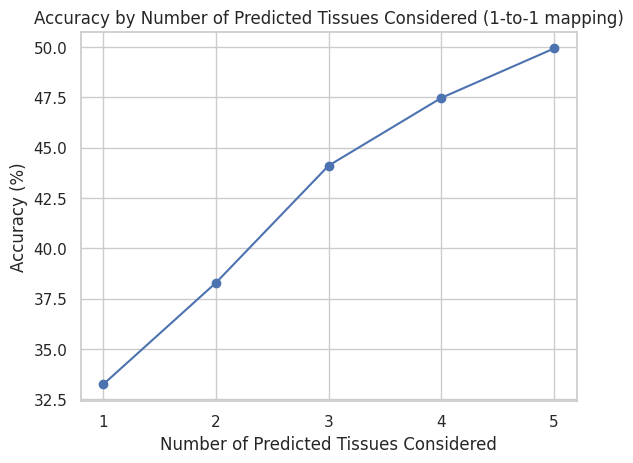

In [55]:
subset = prediction_mapping[['Cohort', 'Cancer_type', 'Correct tissue', 'Predicted tissue 1', 'Predicted tissue 2', 'Predicted tissue 3', 'Predicted tissue 4', 'Predicted tissue 5']]
subset = subset[~subset['Cohort'].isin(['Melanoma', 'Hela', 'PDAC'])]
# List to store accuracies
accuracies = []

# Calculate accuracy for each combination of predicted tissues
for i in range(1, 6):
    correct = subset[
        (subset['Correct tissue'] == subset['Predicted tissue 1']) |
        (subset['Correct tissue'] == subset['Predicted tissue 2']) |
        (subset['Correct tissue'] == subset['Predicted tissue 3']) |
        (subset['Correct tissue'] == subset['Predicted tissue 4']) |
        (subset['Correct tissue'] == subset['Predicted tissue 5'])
    ].iloc[:, :i+3].apply(lambda row: any(row.values[3:] == row['Correct tissue']), axis=1).sum()
    
    total = prediction_mapping.shape[0]
    accuracy = correct / total * 100
    accuracies.append(accuracy)

# Plot the accuracies
plt.plot(range(1, 6), accuracies, marker='o')
plt.xlabel('Number of Predicted Tissues Considered')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy by Number of Predicted Tissues Considered (1-to-1 mapping)')
plt.xticks(range(1, 6))
plt.grid(True)
plt.show()

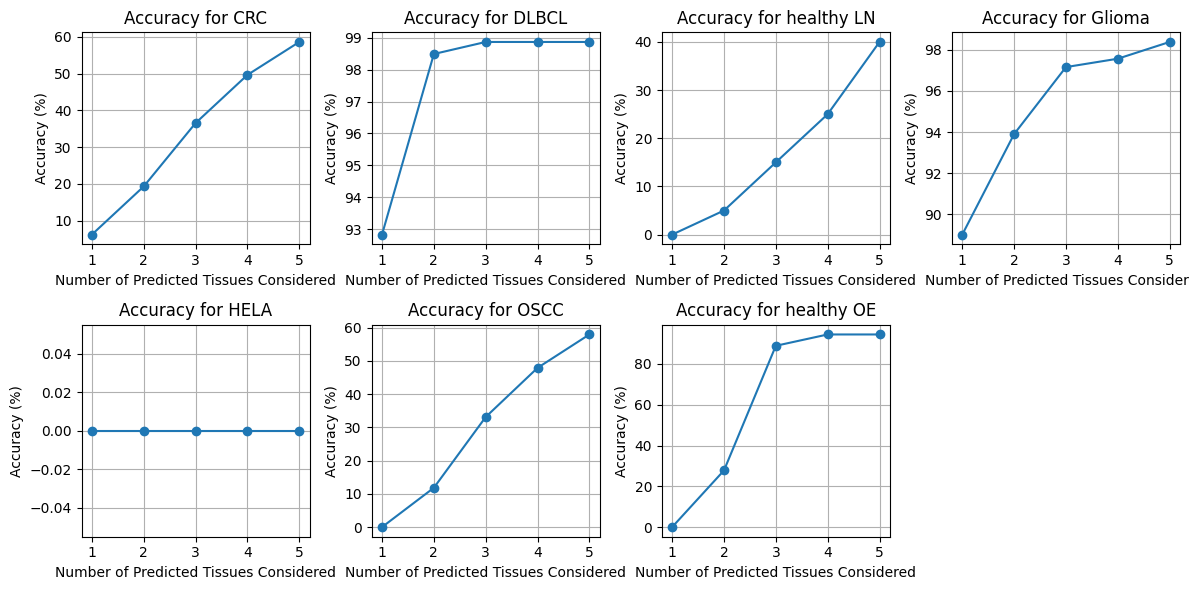

In [14]:
import numpy as np
import matplotlib.pyplot as plt

subset = prediction_mapping[['Cohort', 'Cancer_type', 'Correct tissue', 'Predicted tissue 1', 'Predicted tissue 2', 'Predicted tissue 3', 'Predicted tissue 4', 'Predicted tissue 5']]
subset = subset[~subset['Cohort'].isin(['Melanoma', 'Hela', 'PDAC'])]
cohorts = subset['Cohort'].unique()

# Calculate the number of rows and columns for subplots
num_cols = 4  # Maximum 4 per row
num_rows = (len(cohorts) + num_cols - 1) // num_cols  # Round up to ensure enough rows

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 3))
axs = np.array(axs)

# Flatten the axs array if needed
axs = axs.flatten()

for i, c in enumerate(cohorts):
    cohort_subset = subset[subset['Cohort'] == c]
    # List to store accuracies
    accuracies = []

    # Calculate accuracy for each combination of predicted tissues
    for ix in range(1, 6):
        correct = cohort_subset[
            (cohort_subset['Correct tissue'] == cohort_subset['Predicted tissue 1']) |
            (cohort_subset['Correct tissue'] == cohort_subset['Predicted tissue 2']) |
            (cohort_subset['Correct tissue'] == cohort_subset['Predicted tissue 3']) |
            (cohort_subset['Correct tissue'] == cohort_subset['Predicted tissue 4']) |
            (cohort_subset['Correct tissue'] == cohort_subset['Predicted tissue 5'])
        ].iloc[:, :ix+3].apply(lambda row: any(row.values[3:] == row['Correct tissue']), axis=1).sum()
        
        total = cohort_subset.shape[0]
        accuracy = correct / total * 100
        accuracies.append(accuracy)

    # Plot the accuracies on the corresponding subplot
    axs[i].plot(range(1, 6), accuracies, marker='o')
    axs[i].set_xlabel('Number of Predicted Tissues Considered')
    axs[i].set_ylabel('Accuracy (%)')
    axs[i].set_title(f'Accuracy for {c}')
    axs[i].set_xticks(range(1, 6))
    axs[i].grid(True)

# Hide any unused subplots
for j in range(len(cohorts), len(axs)):
    axs[j].axis('off')

# Adjust the layout and spacing of subplots
plt.tight_layout()

# Show the plot
plt.show()


## Map to multiple tissues instead of 1

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Load metadata and prediction mapping
metadata = pd.read_csv('MassIVE_Mapping.txt', sep='\t')
prediction_mapping_top = prediction_df.T.reset_index()
prediction_mapping_top['sample'] = prediction_mapping_top['index'].str.split(' MaxLFQ Intensity').str[0]
prediction_mapping_top = prediction_mapping_top.merge(metadata[['Cohort', 'Folder name FP_DDA']], left_on='sample', right_on='Folder name FP_DDA').drop_duplicates()
prediction_mapping_top.replace('DLBCL+', 'DLBCL', inplace=True)
# Modify cancer_map to allow multiple tissues for each cancer type
cancer_map = {
    'CRC': ['Colon', 'Small intestine', 'Rectum', 'Duodenum', 'Appendix'], 
    'DLBCL': ['B-cells'], 
    'DLBCL+': ['B-cells'],
    'Glioma': ['Brain', 'Pituitary gland'], 
    'HELA': ['Hela'], 
    'Melanoma': ['Skin'], 
    'PDAC': ['Pancreas'],
    'OSCC': ['Parotid gland', 'Tonsil'],
    'healthy LN': ['Lymph node', 'B-cells', 'Parotid gland'],
    'healthy OE': ['Parotid gland', 'Tonsil']
}

# Map cohorts to multiple tissues
prediction_mapping_top['Correct tissue'] = prediction_mapping_top['Cohort'].map(lambda x: cancer_map.get(x, ['Other']))

# Predicted tissue columns
prediction_mapping_top['Cancer_type'] = prediction_mapping_top.Cohort.map(cohort_map)
prediction_mapping_top['Predicted tissue 1'] = prediction_mapping_top[prediction_mapping_top.columns[1:35]].idxmax(axis=1)
prediction_mapping_top['Predicted tissue 2'] = prediction_mapping_top[prediction_mapping_top.columns[1:35]].apply(lambda x: x.nlargest(2).index.tolist()[1], axis=1)
prediction_mapping_top['Predicted tissue 3'] = prediction_mapping_top[prediction_mapping_top.columns[1:35]].apply(lambda x: x.nlargest(3).index.tolist()[2], axis=1)
prediction_mapping_top['Predicted tissue 4'] = prediction_mapping_top[prediction_mapping_top.columns[1:35]].apply(lambda x: x.nlargest(4).index.tolist()[3], axis=1)
prediction_mapping_top['Predicted tissue 5'] = prediction_mapping_top[prediction_mapping_top.columns[1:35]].apply(lambda x: x.nlargest(5).index.tolist()[4], axis=1)


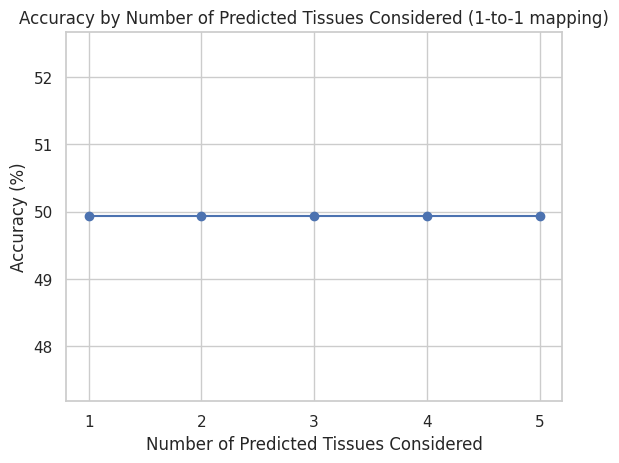

In [50]:
subset = prediction_mapping_top[['Cohort', 'Cancer_type', 'Correct tissue', 'Predicted tissue 1', 'Predicted tissue 2', 'Predicted tissue 3', 'Predicted tissue 4', 'Predicted tissue 5']]
subset = subset[~subset['Cohort'].isin(['Melanoma', 'Hela', 'PDAC'])]
# List to store accuracies
accuracies_top = []

# Calculate accuracy for each combination of predicted tissues
for i in range(1, 6):

    total = prediction_mapping_top.shape[0]
    accuracy = correct / total * 100
    accuracies_top.append(accuracy)

# Plot the accuracies
plt.plot(range(1, 6), accuracies_top, marker='o')
plt.xlabel('Number of Predicted Tissues Considered')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy by Number of Predicted Tissues Considered (1-to-1 mapping)')
plt.xticks(range(1, 6))
plt.grid(True)
plt.show()

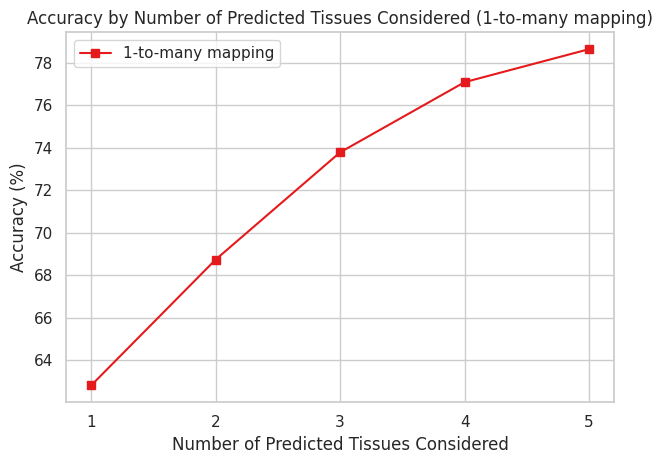

In [51]:
# Subset for plotting and analysis
subset = prediction_mapping[['Cohort', 'Cancer_type', 'Correct tissue', 'Predicted tissue 1', 'Predicted tissue 2', 'Predicted tissue 3', 'Predicted tissue 4', 'Predicted tissue 5']]
subset = subset[~subset['Cohort'].isin(['Melanoma', 'Hela', 'PDAC'])]

subset_top = prediction_mapping_top[['Cohort', 'Cancer_type', 'Correct tissue', 'Predicted tissue 1', 'Predicted tissue 2', 'Predicted tissue 3', 'Predicted tissue 4', 'Predicted tissue 5']]
subset_top = subset_top[~subset_top['Cohort'].isin(['Melanoma', 'Hela', 'PDAC'])]
# List to store accuracies
accuracies_top = []

# Calculate accuracy for each combination of predicted tissues
for i in range(1, 6):
    correct, correct_top = 0, 0
    for _, row in subset_top.iterrows():
        correct_tissues_top = row['Correct tissue']
        predicted_tissues_top = row.iloc[3:i+3].values
        if any(predicted_tissues_top in correct_tissues_top for predicted_tissues_top in predicted_tissues_top):
            correct_top += 1
    total = len(subset)
    accuracy = correct / total * 100
    accuracies.append(accuracy)
    accuracy_top = correct_top/ total * 100
    accuracies_top.append(accuracy_top)
    

# Plot the accuracies

# Use Seaborn's default theme and color palette
sns.set(style="whitegrid")
colors = sns.color_palette("Set1")
plt.plot(range(1,6), accuracies_top, marker='s',  color = colors[0], label='1-to-many mapping')

# Labels and title
plt.xlabel('Number of Predicted Tissues Considered')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy by Number of Predicted Tissues Considered (1-to-many mapping)')
plt.xticks(range(1, 6))
plt.legend()
plt.tight_layout()
plt.show()

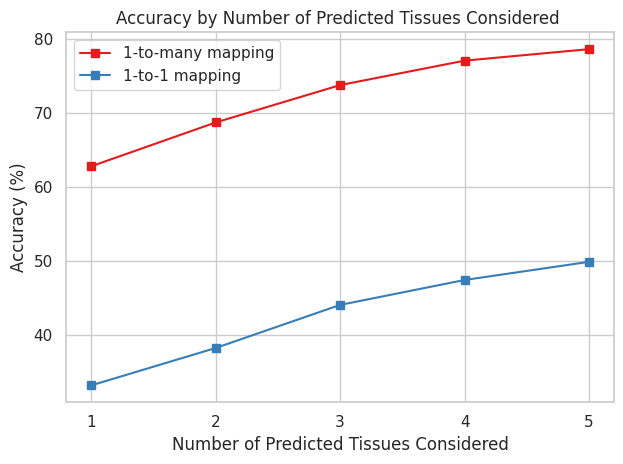

In [57]:
# Use Seaborn's default theme and color palette
sns.set(style="whitegrid")
colors = sns.color_palette("Set1")
plt.plot(range(1,6), accuracies_top, marker='s',  color = colors[0], label='1-to-many mapping')
plt.plot(range(1,6), accuracies, marker='s',  color = colors[1], label='1-to-1 mapping')

# Labels and title
plt.xlabel('Number of Predicted Tissues Considered')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy by Number of Predicted Tissues Considered ')
plt.xticks(range(1, 6))
plt.legend()
plt.tight_layout()
plt.show()

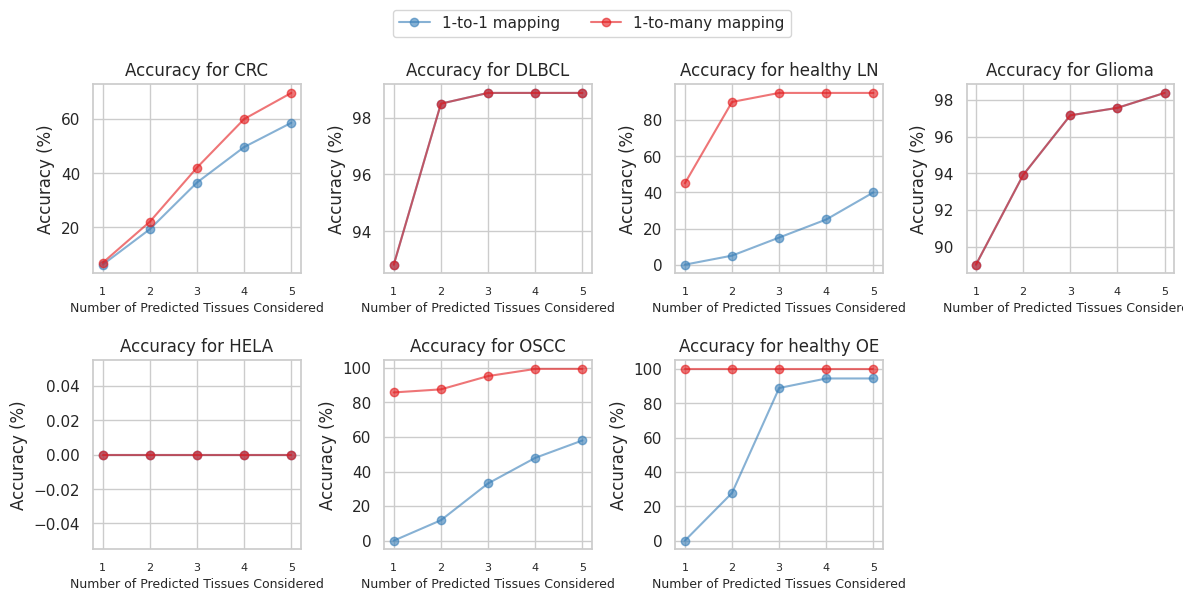

In [44]:
import numpy as np
import matplotlib.pyplot as plt
colors = sns.color_palette("Set1")
# Subset the necessary columns
subset = prediction_mapping[['Cohort', 'Cancer_type', 'Correct tissue', 'Predicted tissue 1', 'Predicted tissue 2', 'Predicted tissue 3', 'Predicted tissue 4', 'Predicted tissue 5']]
subset = subset[~subset['Cohort'].isin(['Melanoma', 'Hela', 'PDAC'])]
cohorts = subset['Cohort'].unique()

subset_top = prediction_mapping_top[['Cohort', 'Cancer_type', 'Correct tissue', 'Predicted tissue 1', 'Predicted tissue 2', 'Predicted tissue 3', 'Predicted tissue 4', 'Predicted tissue 5']]
subset_top = subset_top[~subset_top['Cohort'].isin(['Melanoma', 'Hela', 'PDAC'])]
cohort_subset_top = subset_top['Cohort'].unique()

# Calculate the number of rows and columns for subplots
num_cols = 4  # Maximum 4 per row
num_rows = (len(cohorts) + num_cols - 1) // num_cols  # Round up to ensure enough rows

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 3))
axs = np.array(axs)

# Flatten the axs array if needed
axs = axs.flatten()

for i, c in enumerate(cohorts):
    cohort_subset = subset[subset['Cohort'] == c]
    cohort_subset_top = subset_top[subset_top['Cohort'] == c]
    # List to store accuracies
    accuracies, accuracies_top = [], []

    # Calculate accuracy for each combination of predicted tissues
    for ix in range(1, 6):
        correct, correct_top = 0, 0
        for _, row in cohort_subset.iterrows():
            correct_tissues = row['Correct tissue']
            predicted_tissues = row.iloc[3:ix+3].values  # Select the predicted tissues up to the i-th one
            # Check if any of the predicted tissues match any of the correct tissues
            if any(predicted_tissue in correct_tissues for predicted_tissue in predicted_tissues):
                correct += 1
        for _, row in cohort_subset_top.iterrows():
            correct_tissues_top = row['Correct tissue']
            predicted_tissues_top = row.iloc[3:ix+3].values  # Select the predicted tissues up to the i-th one
            # Check if any of the predicted tissues match any of the correct tissues
            if any(predicted_tissue_top in correct_tissues_top for predicted_tissue_top in predicted_tissues_top):
                correct_top += 1
        total = cohort_subset.shape[0]
        accuracy = correct / total * 100
        accuracies.append(accuracy)
        
        total = cohort_subset_top.shape[0]
        accuracy_top = correct_top / total * 100
        accuracies_top.append(accuracy_top)

    # Plot the accuracies on the corresponding subplot
    axs[i].plot(range(1, 6), accuracies, marker='o', alpha=0.60, color=colors[1], label='1-to-1 mapping')
    axs[i].plot(range(1, 6), accuracies_top, marker='o', alpha=0.60, color=colors[0], label='1-to-many mapping')
    axs[i].set_xlabel('Number of Predicted Tissues Considered', fontsize=9)  # Changed labelsize to fontsize
    axs[i].set_ylabel('Accuracy (%)')
    axs[i].set_title(f'Accuracy for {c}')
    axs[i].set_xticks(range(1, 6))
    axs[i].grid(True)

# Hide any unused subplots
for j in range(len(cohorts), len(axs)):
    axs[j].axis('off')

# Adjust the layout and spacing of subplots
# Adjust the layout and spacing of subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])
# Make x-axis text smaller
for ax in axs:
    ax.tick_params(axis='x', labelsize=8)  # Reduce font size for x-axis labels

# Add a single legend for the entire figure, moved slightly higher
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.02))

# Show the plot
plt.show()


KeyError: 'Correct tissue'

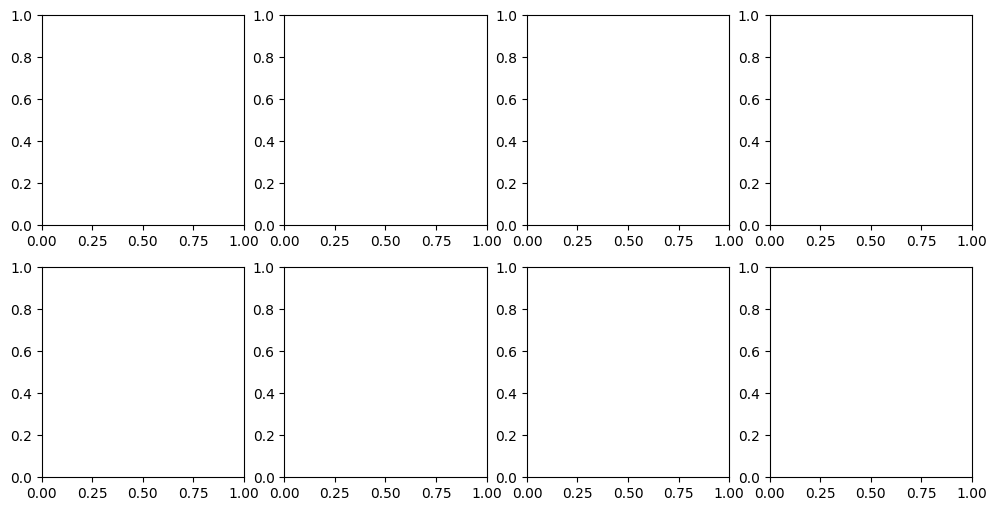

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Subset the necessary columns
subset = prediction_mapping_top[['Cohort', 'Cancer_type', 'Correct tissue', 'Predicted tissue 1', 'Predicted tissue 2', 'Predicted tissue 3', 'Predicted tissue 4', 'Predicted tissue 5']]
subset = subset[~subset['Cohort'].isin(['Melanoma', 'Hela', 'PDAC'])]
cohorts = subset['Cohort'].unique()

# Calculate the number of rows and columns for subplots
num_cols = 4  # Maximum 4 per row
num_rows = (len(cohorts) + num_cols - 1) // num_cols  # Round up to ensure enough rows

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 3))
axs = np.array(axs)

# Flatten the axs array if needed
axs = axs.flatten()

for i, c in enumerate(cohorts):
    cohort_subset = subset[subset['Cohort'] == c]
    # List to store accuracies
    accuracies = []

    # Calculate accuracy for each combination of predicted tissues
    for ix in range(1, 6):
        correct = 0
        for _, row in cohort_subset.iterrows():
            correct_tissues = row['Correct tissue']
            predicted_tissues = row.iloc[3:ix+3].values  # Select the predicted tissues up to the i-th one
            # Check if any of the predicted tissues match any of the correct tissues
            if any(predicted_tissue in correct_tissues for predicted_tissue in predicted_tissues):
                correct += 1
        
        total = cohort_subset.shape[0]
        accuracy = correct / total * 100
        accuracies.append(accuracy)

    # Plot the accuracies on the corresponding subplot
    axs[i].plot(range(1, 6), accuracies, marker='o')
    axs[i].set_xlabel('Number of Predicted Tissues Considered')
    axs[i].set_ylabel('Accuracy (%)')
    axs[i].set_title(f'Accuracy for {c}')
    axs[i].set_xticks(range(1, 6))
    axs[i].grid(True)

# Hide any unused subplots
for j in range(len(cohorts), len(axs)):
    axs[j].axis('off')

# Adjust the layout and spacing of subplots
plt.tight_layout()

# Show the plot
plt.show()


In [27]:
grouped_random_prediction_df = prediction_df[['Random_Expression_1', 'Zero_Column']].T
grouped_random_prediction_df[grouped_random_prediction_df < 0] = 0
grouped_random_prediction_df = grouped_random_prediction_df.apply(lambda x: x.nlargest(35).where(x >= x.nlargest(35).min(), 0), axis=1).fillna(0)
grouped_random_prediction_df = grouped_random_prediction_df.loc[:, (grouped_random_prediction_df !=0).any(axis=0)]
grouped_random_prediction_df

tissue               Adipose tissue  Adrenal gland  Appendix  Bone marrow  \
Random_Expression_1         0.00000        0.00000   0.00000      0.00000   
Zero_Column                 0.00089        0.00007   0.00029      0.00567   

tissue                 Brain    Colon  Esophagus    Heart   Kidney    Liver  \
Random_Expression_1  0.00000  0.00000    0.00421  0.05175  0.00000  0.00000   
Zero_Column          0.00084  0.00173    0.00098  0.00017  0.00096  0.00085   

tissue               ...  Parotid gland  Pituitary gland  Placenta  \
Random_Expression_1  ...        0.00798          0.01805   0.00000   
Zero_Column          ...        0.00000          0.00000   0.00086   

tissue               Salivary gland  Skeletal muscle   Spleen  Stomach  \
Random_Expression_1         0.00078          0.21777  0.00000  0.00000   
Zero_Column                 0.00081          0.00000  0.00109  0.00017   

tissue                Testis  Tonsil  Urinary bladder  
Random_Expression_1  0.00870  0.0437          0.00000  
Zero_Column          0.00181  0.0000          0.00041  

[2 rows x 23 columns]

In [28]:
grouped_df = prediction_mapping.set_index('Cohort')[tissues]
grouped_df = grouped_df.groupby('Cohort').mean()
grouped_df[grouped_df < 0] = 0


#per row only keep the 10 highest values, turn the rest to 0
grouped_df = grouped_df.apply(lambda x: x.nlargest(35).where(x >= x.nlargest(35).min(), 0), axis=1).fillna(0)
#drop columns with only zero
grouped_df = grouped_df.loc[:, (grouped_df !=0).any(axis=0)]
print(grouped_df.shape)

grouped_df = pd.concat([grouped_df, grouped_random_prediction_df]).fillna(0)
grouped_df

(9, 24)


Appendix   B-cells     Brain     Colon  Duodenum  \
CRC                  0.000093  0.053064  0.000000  0.036764  0.014646   
DLBCL                0.013215  0.198779  0.000000  0.000000  0.000000   
Glioma               0.000000  0.047851  0.287968  0.000000  0.000000   
HELA                 0.000000  0.129160  0.000000  0.002575  0.000000   
Melanoma             0.004346  0.116284  0.024929  0.000000  0.000000   
OSCC                 0.000000  0.029062  0.000000  0.000000  0.000000   
PDAC                 0.000000  0.048733  0.000000  0.019894  0.024972   
healthy LN           0.000000  0.108279  0.000000  0.000000  0.000000   
healthy OE           0.000000  0.030218  0.000000  0.000000  0.000000   
Random_Expression_1  0.000000  0.000000  0.000000  0.000000  0.000000   
Zero_Column          0.000290  0.000000  0.000840  0.001730  0.000000   

                     Esophagus     Heart    Kidney     Liver  Lymph node  ...  \
CRC                   0.000000  0.000000  0.000000  0.015026    0.000000  ...   
DLBCL                 0.000000  0.004720  0.000000  0.002444    0.029291  ...   
Glioma                0.000000  0.000000  0.000000  0.000000    0.000000  ...   
HELA                  0.000000  0.000000  0.047376  0.029325    0.006209  ...   
Melanoma              0.000000  0.000629  0.015064  0.004054    0.000000  ...   
OSCC                  0.037614  0.025037  0.000000  0.000461    0.000000  ...   
PDAC                  0.000000  0.000000  0.009044  0.001532    0.000000  ...   
healthy LN            0.002366  0.000140  0.000000  0.000000    0.013614  ...   
healthy OE            0.037731  0.000000  0.000000  0.000000    0.000000  ...   
Random_Expression_1   0.004210  0.051750  0.000000  0.000000    0.000000  ...   
Zero_Column           0.000980  0.000170  0.000960  0.000850    0.000000  ...   

                     Small intestine    Spleen   Stomach    Testis    Tonsil  \
CRC                         0.002485  0.000000  0.000000  0.020991  0.021439   
DLBCL                       0.000000  0.005466  0.000000  0.023598  0.023082   
Glioma                      0.000000  0.000000  0.000000  0.019453  0.003686   
HELA                        0.000000  0.000000  0.000000  0.024623  0.000000   
Melanoma                    0.000000  0.000000  0.000000  0.030260  0.036546   
OSCC                        0.000000  0.000000  0.000000  0.007378  0.210691   
PDAC                        0.000000  0.000000  0.023279  0.026700  0.042178   
healthy LN                  0.000000  0.000000  0.000000  0.017266  0.174751   
healthy OE                  0.000000  0.000000  0.000000  0.013257  0.304584   
Random_Expression_1         0.000000  0.000000  0.000000  0.008700  0.043700   
Zero_Column                 0.000000  0.001090  0.000170  0.001810  0.000000   

                     Adipose tissue  Adrenal gland  Bone marrow     Lung  \
CRC                         0.00000        0.00000      0.00000  0.00000   
DLBCL                       0.00000        0.00000      0.00000  0.00000   
Glioma                      0.00000        0.00000      0.00000  0.00000   
HELA                        0.00000        0.00000      0.00000  0.00000   
Melanoma                    0.00000        0.00000      0.00000  0.00000   
OSCC                        0.00000        0.00000      0.00000  0.00000   
PDAC                        0.00000        0.00000      0.00000  0.00000   
healthy LN                  0.00000        0.00000      0.00000  0.00000   
healthy OE                  0.00000        0.00000      0.00000  0.00000   
Random_Expression_1         0.00000        0.00000      0.00000  0.00000   
Zero_Column                 0.00089        0.00007      0.00567  0.00218   

                     Urinary bladder  
CRC                          0.00000  
DLBCL                        0.00000  
Glioma                       0.00000  
HELA                         0.00000  
Melanoma                     0.00000  
OSCC                         0.00000  
PDAC                    

In [29]:

import colorsys

def generate_unique_colors(n, saturation=0.8, lightness=0.6):
    """
    Generate `n` visually distinct colors using HSL color space.
    
    Parameters:
        n (int): Number of unique colors required.
        saturation (float): Saturation level of the colors (0 to 1). Default is 0.8.
        lightness (float): Lightness level of the colors (0 to 1). Default is 0.6.
    
    Returns:
        list: List of RGB tuples.
    """
    if n <= 0:
        raise ValueError("Number of colors must be greater than 0.")
    
    hues = [i / n for i in range(n)]  # Evenly spaced hues
    colors = [colorsys.hls_to_rgb(h, lightness, saturation) for h in hues]
    return colors

import itertools

def generate_distinct_colors(n):
    """
    Generate `n` visually distinct colors using predefined categorical palettes and strategies.
    
    Parameters:
        n (int): Number of distinct colors required.
    
    Returns:
        list: List of RGB tuples.
    """
    # Start with a well-known palette with maximally distinct colors
    base_colors = [
        "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
        "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"
    ]  # Matplotlib Tableau colors
    
    # Expand to more colors using Glasbey palette (from seaborn, matplotlib)
    if n > len(base_colors):
        try:
            import colorcet as cc
            extended_colors = cc.glasbey[:n]
        except ImportError:
            # Fallback to Seaborn or manually generate
            extended_colors = sns.color_palette("tab20", n).as_hex()
    else:
        extended_colors = base_colors[:n]
    
    return extended_colors

from matplotlib.colors import to_hex

def generate_cohesive_distinct_colors(n, palette_name="Set2"):
    """
    Generate `n` visually distinct and cohesive colors based on a given palette.

    Parameters:
        n (int): Number of distinct colors required.
        palette_name (str): Name of the color palette to use (e.g., "tab10", "pastel", "deep", "dark").
    
    Returns:
        list: List of HEX color codes.
    """
    # Generate a palette from Seaborn or Matplotlib
    if n <= 20:  # Use predefined palettes for smaller sets
        palette = sns.color_palette(palette_name, n)
    else:  # Generate a larger palette if needed
        palette = sns.color_palette("husl", n)  # HUSL provides a wide range of distinct hues

    # Convert colors to HEX for consistent use
    colors_hex = [to_hex(color) for color in palette]
    return colors_hex


(array([], dtype=float64), [])

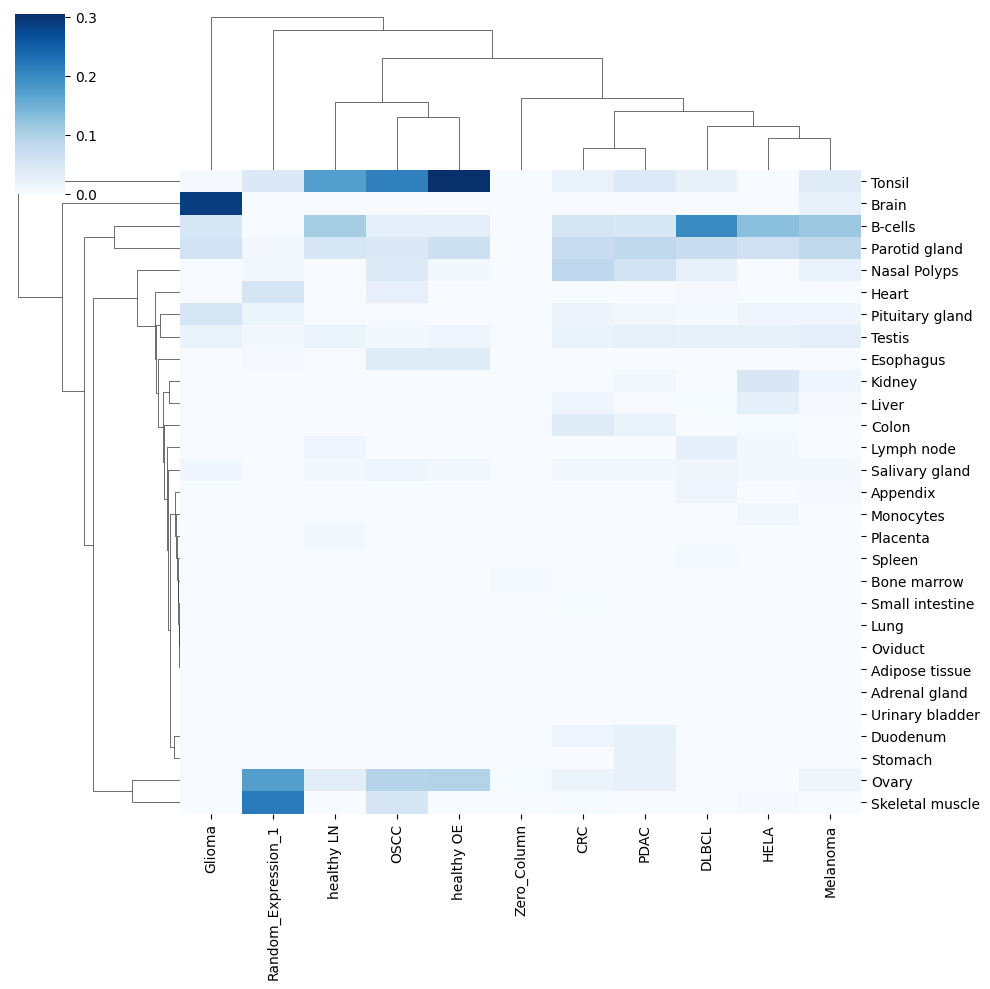

In [30]:
sns.clustermap(grouped_df.T, cmap="Blues")
plt.xticks(rotation=45)

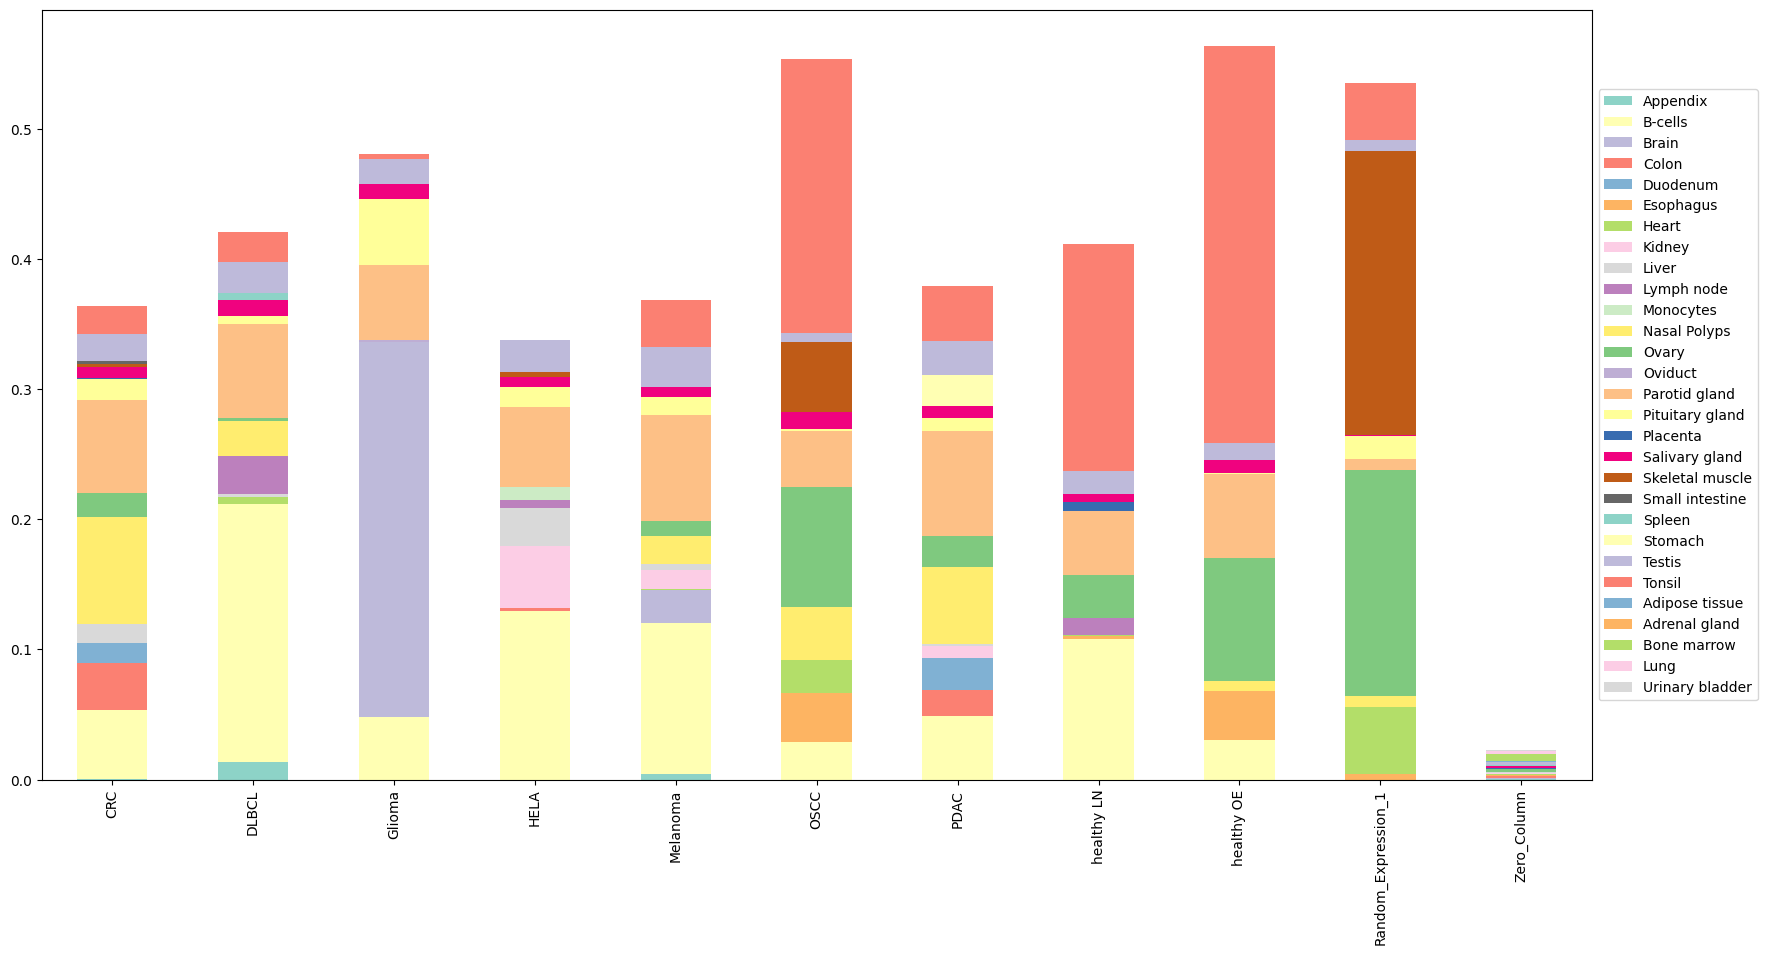

In [31]:
#make a stacked barplot per cohort
import matplotlib.colors as mcolors

palette = sns.color_palette("Set3") + sns.color_palette("Accent")
colors = [to_hex(color) for color in palette]
#get 23 unique colours for 
# colors  =generate_cohesive_distinct_colors(grouped_df.shape[1])

grouped_df.plot(kind='bar', stacked=True, figsize=(20,10), color=colors)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


In the original paper, they checked the proteome correlation, does this transfer to prediction correlation?   
Expected behaviour: correlation within cohorts   
DLBCL and DLBCL+ cohort correlation   
healthy LN and DLBCL correlation  
healthy OE and OSCC correlation   
Outliers: brain samples metastasis cancers  from MEL cohort:

originally through UMAP   


To check: the original paper had the MEL cohort, these are melanoma samples! can we find the ones that are brain metastasis?

In [32]:
prediction_mapping.columns

Index(['index', 'Adipose tissue', 'Adrenal gland', 'Appendix', 'B-cells',
       'Bone marrow', 'Brain', 'Colon', 'Duodenum', 'Endometrium', 'Esophagus',
       'Heart', 'Kidney', 'Liver', 'Lung', 'Lymph node', 'Monocytes',
       'Nasal Polyps', 'Ovary', 'Oviduct', 'Parotid gland', 'Pituitary gland',
       'Placenta', 'Prostate', 'Rectum', 'Salivary gland', 'Skeletal muscle',
       'Small intestine', 'Smooth muscle', 'Spleen', 'Stomach', 'Testis',
       'Thyroid', 'Tonsil', 'Urinary bladder', 'sample', 'Cohort',
       'Folder name FP_DDA', 'Correct tissue', 'Cancer_type',
       'Predicted tissue 1', 'Predicted tissue 2', 'Predicted tissue 3',
       'Predicted tissue 4', 'Predicted tissue 5'],
      dtype='object')

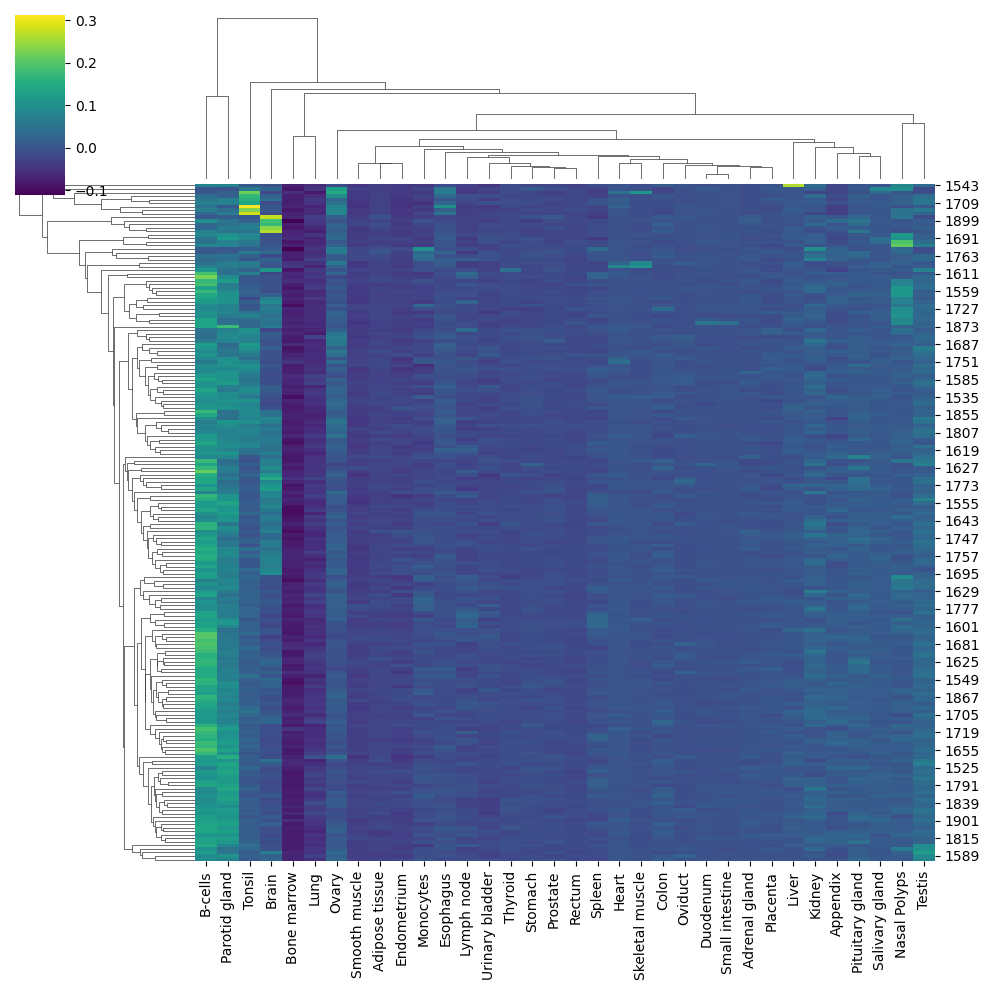

In [33]:
sns.clustermap(prediction_mapping[prediction_mapping['Cohort'] == 'Melanoma'].iloc[:, 1:35], cmap='viridis', figsize=(10,10))

In [34]:
prediction_mapping['ID'] = prediction_mapping['Cohort'] + '_' + prediction_mapping['Folder name FP_DDA']
prediction_mapping_corr = prediction_mapping.set_index('ID')[tissues]
prediction_mapping_corr

Adipose tissue  Adrenal gland  Appendix  B-cells  \
ID                                                                   
CRC_P066172_1           -0.02988       -0.00513   0.02924  0.06433   
CRC_P066173_2           -0.02907       -0.01148   0.00918  0.00135   
CRC_P066174_3           -0.02590       -0.00632  -0.00731  0.10691   
CRC_P066175_4           -0.03079       -0.00494  -0.02112  0.05316   
CRC_P066176_5           -0.02397       -0.01179  -0.00938  0.01478   
...                          ...            ...       ...      ...   
PDAC_P053271_201        -0.02296        0.00707  -0.00330  0.06720   
PDAC_P053272_202        -0.03480       -0.00938  -0.01206  0.04397   
PDAC_P053273_203        -0.03545       -0.00131   0.00448  0.05222   
PDAC_P053274_204        -0.03265       -0.00849  -0.00696  0.05368   
PDAC_P053275_205        -0.02791       -0.00611  -0.01775  0.02663   

                  Bone marrow    Brain    Colon  Duodenum  Endometrium  \
ID                                                                       
CRC_P066172_1        -0.06602 -0.01870  0.02077  -0.00208     -0.02512   
CRC_P066173_2        -0.06128 -0.01381  0.06013   0.00001     -0.02899   
CRC_P066174_3        -0.07057 -0.00808  0.01104   0.01895     -0.03018   
CRC_P066175_4        -0.06031 -0.00646  0.02392   0.06228     -0.03186   
CRC_P066176_5        -0.06240  0.00488  0.04557   0.02446     -0.03304   
...                       ...      ...      ...       ...          ...   
PDAC_P053271_201     -0.07253  0.00329 -0.00762   0.00339     -0.01847   
PDAC_P053272_202     -0.07197  0.00385  0.04185   0.02326     -0.03732   
PDAC_P053273_203     -0.07698  0.01682  0.01562   0.00107     -0.03674   
PDAC_P053274_204     -0.07835 -0.01218  0.00542   0.02663     -0.03652   
PDAC_P053275_205     -0.06497 -0.02411  0.02709   0.01871     -0.04128   

                  Esophagus  ...  Salivary gland  Skeletal muscle  \
ID                           ...                                    
CRC_P066172_1      -0.01752  ...         0.00944         -0.00466   
CRC_P066173_2       0.03623  ...         0.01687         -0.00502   
CRC_P066174_3      -0.02332  ...         0.00407         -0.00505   
CRC_P066175_4      -0.01161  ...         0.00075         -0.00510   
CRC_P066176_5      -0.02107  ...         0.00189         -0.00765   
...                     ...  ...             ...              ...   
PDAC_P053271_201   -0.01402  ...         0.01843         -0.00365   
PDAC_P053272_202   -0.01812  ...         0.00084         -0.00415   
PDAC_P053273_203   -0.00131  ...         0.01886         -0.00356   
PDAC_P053274_204   -0.02089  ...         0.01515          0.00113   
PDAC_P053275_205   -0.00774  ...         0.00338         -0.01314   

                  Small intestine  Smooth muscle   Spleen  Stomach   Testis  \
ID                                                                            
CRC_P066172_1             0.00022       -0.04164 -0.00906 -0.02561  0.02650   
CRC_P066173_2            -0.00351       -0.02244 -0.03102 -0.00422 -0.00348   
CRC_P066174_3             0.00460       -0.03920 -0.00994 -0.02150  0.01106   
CRC_P066175_4             0.02750       -0.04108 -0.01551 -0.00609  0.00691   
CRC_P066176_5             0.01004       -0.04241 -0.01829  0.02482 -0.00858   
...                           ...            ...      ...      ...      ...   
PDAC_P053271_201         -0.00424       -0.03444 -0.00990  0.00352  0.03707   
PDAC_P053272_202          0.00046       -0.03575 -0.00626  0.05880  0.02494   
PDAC_P053273_203         -0.00852       -0.02413 -0.01608 -0.01037  0.01174   
PDAC_P053274_204         -0.00687       -0.03791 -0.01395  0.04778  0.03716   
PDAC_P053275_205         -0.00429       -0.02797 -0.01479  0.01943  0.01832   

                  Thyroid   Tonsil  Urinary bladder  
ID                                                   
CRC_P066172_1    -0.01333  0.02894         -0.01496  
CRC_P066173_2    -0.01992  0.10477          0.00251  
CR

Can we idenitfy the MEL cohort by umap clustering of the glioma data?  

Do the misclustering happens at both protein and prediciton level?

In [35]:
import umap
reducer = umap.UMAP()
df_filtered = df.filter(like='MaxLFQ')

embedding = reducer.fit_transform(df_filtered.T.fillna(0))


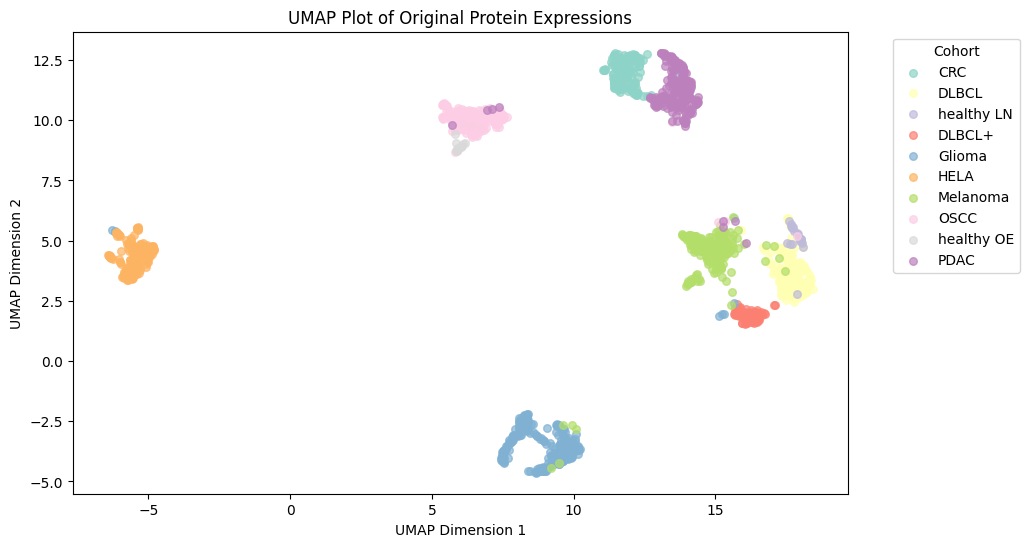

In [36]:

embedding_df = pd.DataFrame(embedding)
embedding_df['ID'] = df_filtered.columns
embedding_df['ID'] = embedding_df['ID'].str.split(' MaxLFQ Intensity').str[0]
embedding_df = embedding_df.merge(metadata[['Cohort', 'Folder name FP_DDA']], left_on='ID', right_on='Folder name FP_DDA').drop_duplicates()

cohorts = embedding_df['Cohort'].unique()
palette = sns.color_palette("Set3", len(cohorts))
color_mapping = {category: palette[i] for i, category in enumerate(cohorts)}

plt.figure(figsize=(10, 6))
for cohort, color in color_mapping.items():
    cohort_data = embedding_df[embedding_df['Cohort'] == cohort]
    plt.scatter(cohort_data[0], cohort_data[1], label=cohort, color=color, s=30, alpha=0.7)

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Plot of Original Protein Expressions')
plt.legend(title='Cohort', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



### Now only for mlmarker fature proteins

In [37]:
features = model.get_model_features()

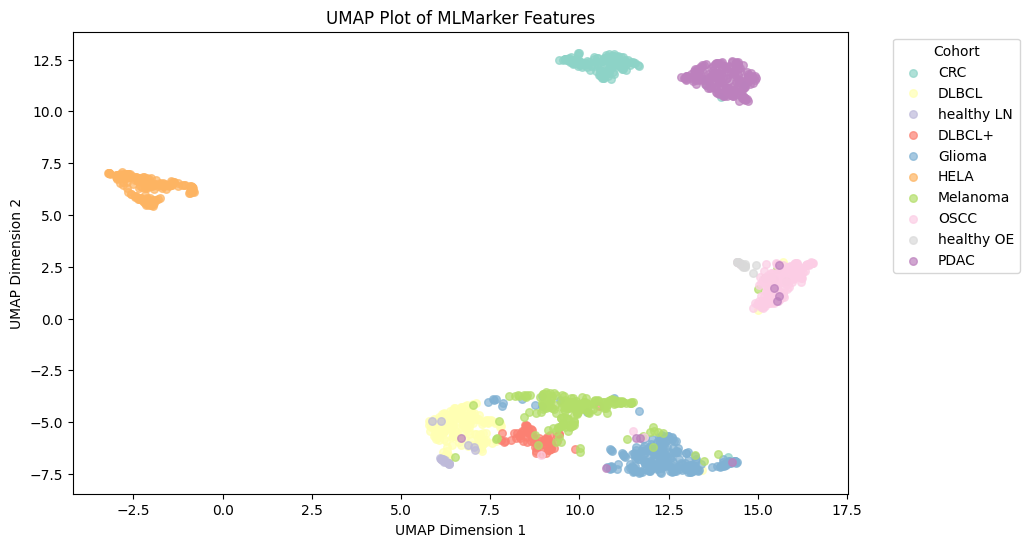

In [38]:
import umap
reducer = umap.UMAP()
df_filtered = df[df['Protein ID'].isin(features)]
df_filtered = df_filtered.filter(like='MaxLFQ')
embedding = reducer.fit_transform(df_filtered.T.fillna(0))

embedding_df = pd.DataFrame(embedding)
embedding_df['ID'] = df_filtered.columns
embedding_df['ID'] = embedding_df['ID'].str.split(' MaxLFQ Intensity').str[0]
embedding_df = embedding_df.merge(metadata[['Cohort', 'Folder name FP_DDA']], left_on='ID', right_on='Folder name FP_DDA').drop_duplicates()

cohorts = embedding_df['Cohort'].unique()
palette = sns.color_palette("Set3", len(cohorts))
color_mapping = {category: palette[i] for i, category in enumerate(cohorts)}

plt.figure(figsize=(10, 6))
for cohort, color in color_mapping.items():
    cohort_data = embedding_df[embedding_df['Cohort'] == cohort]
    plt.scatter(cohort_data[0], cohort_data[1], label=cohort, color=color, s=30, alpha=0.7)

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Plot of MLMarker Features')
plt.legend(title='Cohort', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



# Here we can clearly see the MEL samples that classify on protein level with Glioma

In [39]:
import umap
reducer = umap.UMAP()
embedding_pred = prediction_df.copy()
embedding_pred[embedding_pred < 0] = 0

embedding_pred = reducer.fit_transform(embedding_pred.T.fillna(0))
embedding_pred_df = pd.DataFrame(embedding_pred)

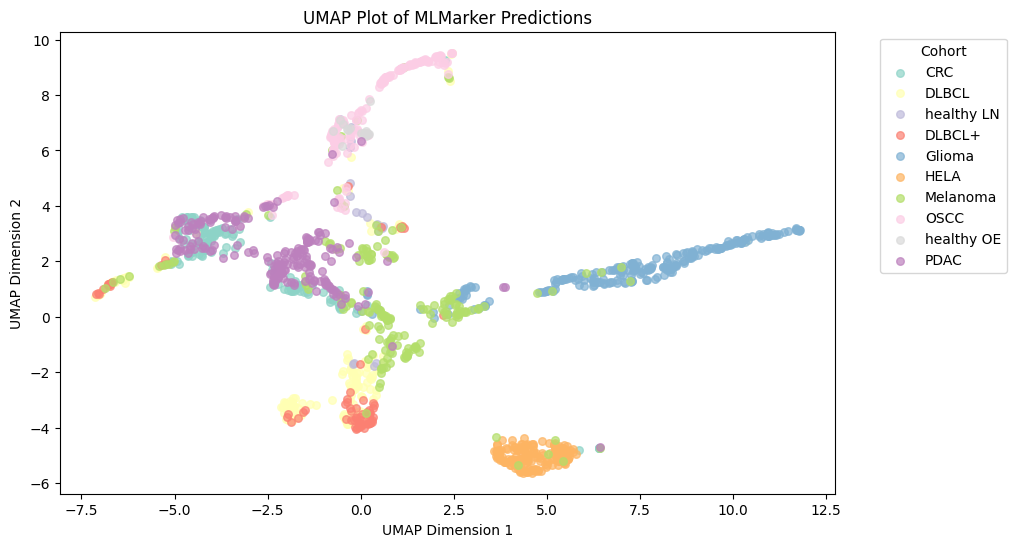

In [40]:
embedding_pred_df['ID'] = prediction_df.columns
embedding_pred_df['ID'] = embedding_pred_df['ID'].str.split(' MaxLFQ Intensity').str[0]
embedding_pred_df = embedding_pred_df.merge(metadata[['Cohort', 'Folder name FP_DDA']], left_on='ID', right_on='Folder name FP_DDA').drop_duplicates()


cohorts = embedding_pred_df['Cohort'].unique()
palette = sns.color_palette("Set3", len(cohorts))
color_mapping = {category: palette[i] for i, category in enumerate(cohorts)}

plt.figure(figsize=(10, 6))
for cohort, color in color_mapping.items():
    cohort_data = embedding_pred_df[embedding_pred_df['Cohort'] == cohort]
    plt.scatter(cohort_data[0], cohort_data[1], label=cohort, color=color, s=30, alpha=0.7)

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Plot of MLMarker Predictions')
plt.legend(title='Cohort', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



# From EV1file we can now which samples are brain metastasis in melanoma

In [41]:
matching_names = ["P063693","P063704", "P064962", "P064964", "P064965", "P064972", "P064989", "P064997", "P065090", "P065098", "P065099", "P065104", "P065109", "P065115", "P065117", "P065123", "P065128", "P065130", "P065134", "P065194", "P065195", "P065212", "P065213", "P065214", "P065217", "P065218", "P065219", "P065220", "P065221", "P065226", "P065444", "P065445", "P065446", "P065447"]
brain_mel_samples = [name for name in embedding_pred_df['ID'] if any(sample in name for sample in matching_names)]
embedding_pred_df['Brain_metastasis'] = embedding_pred_df['ID'].isin(brain_mel_samples)

In [42]:
prediction_mapping['Brain_metastasis'] = prediction_mapping['index'].str.split(' MaxLFQ Intensity').str[0].isin(brain_mel_samples)

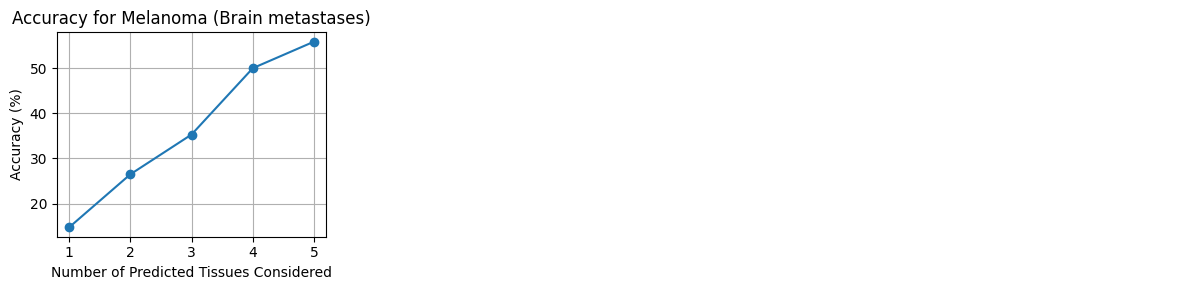

In [43]:
#from how many of these brain metastasis is Brain in the top 5?
brain_subset = prediction_mapping[prediction_mapping['Brain_metastasis'] == True]
brain_subset['Correct tissue'] = 'Brain'
subset = brain_subset[['Cohort', 'Cancer_type', 'Correct tissue', 'Predicted tissue 1', 'Predicted tissue 2', 'Predicted tissue 3', 'Predicted tissue 4', 'Predicted tissue 5']]
cohorts = subset['Cohort'].unique()

# Calculate the number of rows and columns for subplots
num_cols = 4  # Maximum 4 per row
num_rows = (len(cohorts) + num_cols - 1) // num_cols  # Round up to ensure enough rows

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 3))
axs = np.array(axs)

# Flatten the axs array if needed
axs = axs.flatten()

for i, c in enumerate(cohorts):
    cohort_subset = subset[subset['Cohort'] == c]
    # List to store accuracies
    accuracies = []

    # Calculate accuracy for each combination of predicted tissues
    for ix in range(1, 6):
        correct = 0
        for _, row in cohort_subset.iterrows():
            correct_tissues = row['Correct tissue']
            predicted_tissues = row.iloc[3:ix+3].values  # Select the predicted tissues up to the i-th one
            # Check if any of the predicted tissues match any of the correct tissues
            if any(predicted_tissue in correct_tissues for predicted_tissue in predicted_tissues):
                correct += 1
        
        total = cohort_subset.shape[0]
        accuracy = correct / total * 100
        accuracies.append(accuracy)

    # Plot the accuracies on the corresponding subplot
    axs[i].plot(range(1, 6), accuracies, marker='o')
    axs[i].set_xlabel('Number of Predicted Tissues Considered')
    axs[i].set_ylabel('Accuracy (%)')
    axs[i].set_title(f'Accuracy for {c} (Brain metastases)')
    axs[i].set_xticks(range(1, 6))
    axs[i].grid(True)

# Hide any unused subplots
for j in range(len(cohorts), len(axs)):
    axs[j].axis('off')

# Adjust the layout and spacing of subplots
plt.tight_layout()

# Show the plot
plt.show()


/tmp/ipykernel_126525/2918851052.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(prediction_mapping[prediction_mapping['Cancer_type'] == 'melanoma'][prediction_mapping['Brain_metastasis'] == True]['Brain'], label='Known Brain Metastasis')
/tmp/ipykernel_126525/2918851052.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(prediction_mapping[prediction_mapping['Cancer_type'] == 'melanoma'][prediction_mapping['Brain_metastasis'] == False]['Brain'], label='Not Brain Metastasis')


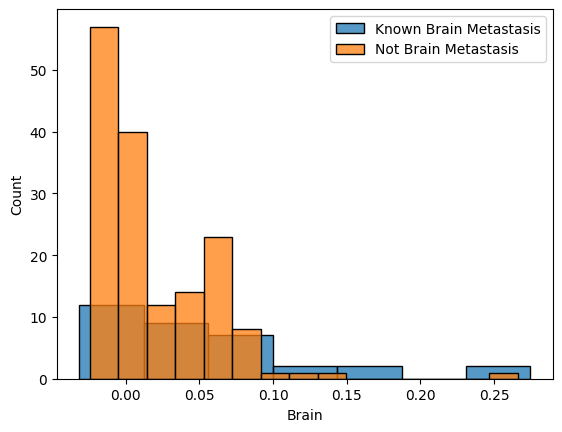

In [44]:
sns.histplot(prediction_mapping[prediction_mapping['Cancer_type'] == 'melanoma'][prediction_mapping['Brain_metastasis'] == True]['Brain'], label='Known Brain Metastasis')
sns.histplot(prediction_mapping[prediction_mapping['Cancer_type'] == 'melanoma'][prediction_mapping['Brain_metastasis'] == False]['Brain'], label='Not Brain Metastasis')
plt.legend()


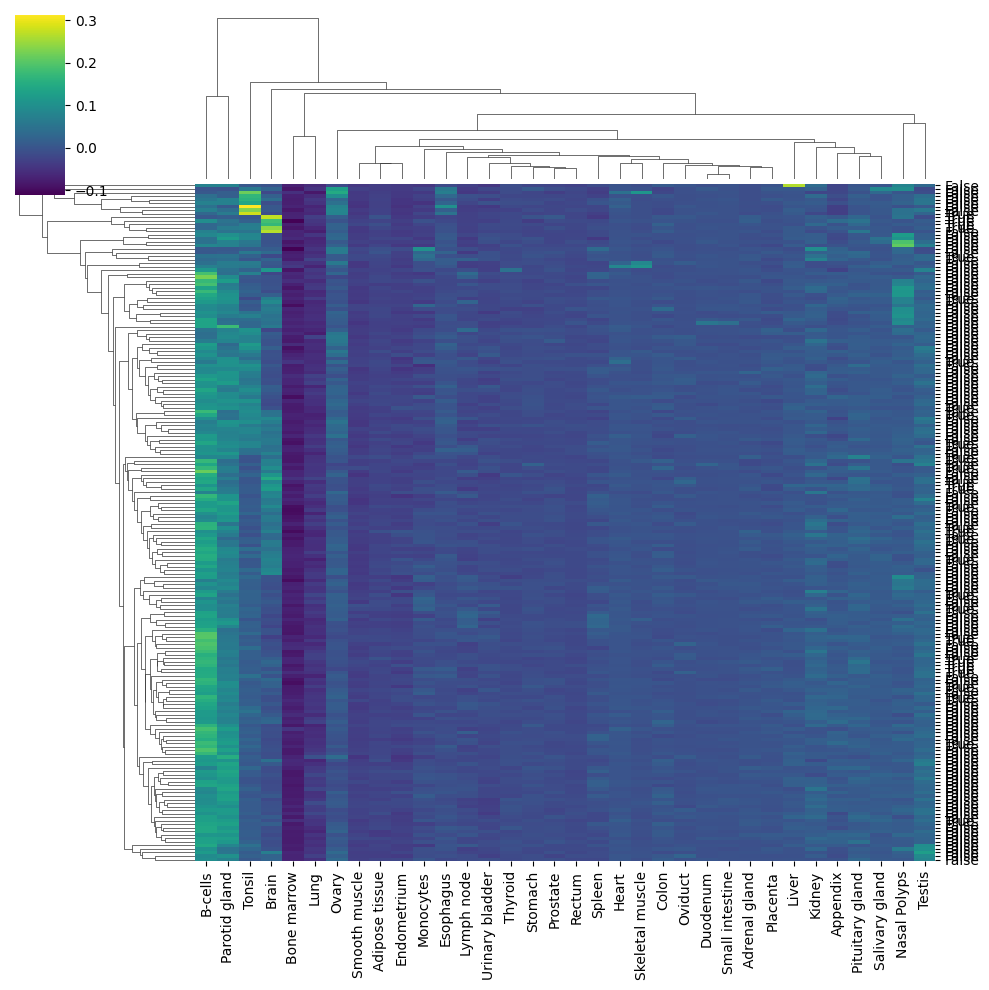

In [45]:
sns.clustermap(prediction_mapping[prediction_mapping['Cohort'] == 'Melanoma'].iloc[:, 1:35], 
               cmap='viridis', 
               figsize=(10,10),
               yticklabels=prediction_mapping[prediction_mapping['Cohort'] == 'Melanoma']['Brain_metastasis'])


In [46]:
# Example DataFrame with a 'True/False' column
embedding_pred_df['marker_size'] = embedding_pred_df['Brain_metastasis'].apply(lambda x: 10 if x else 1.5)

# Create the Plotly Express scatter plot
fig = px.scatter(
    embedding_pred_df, 
    x=0, y=1, 
    color='Cohort', 
    size='marker_size',
    hover_data=['ID'],
    labels={'Cohort': 'Cohort'}, 
    title='UMAP Plot of Protein Colored by Cohort'
)

fig.show()


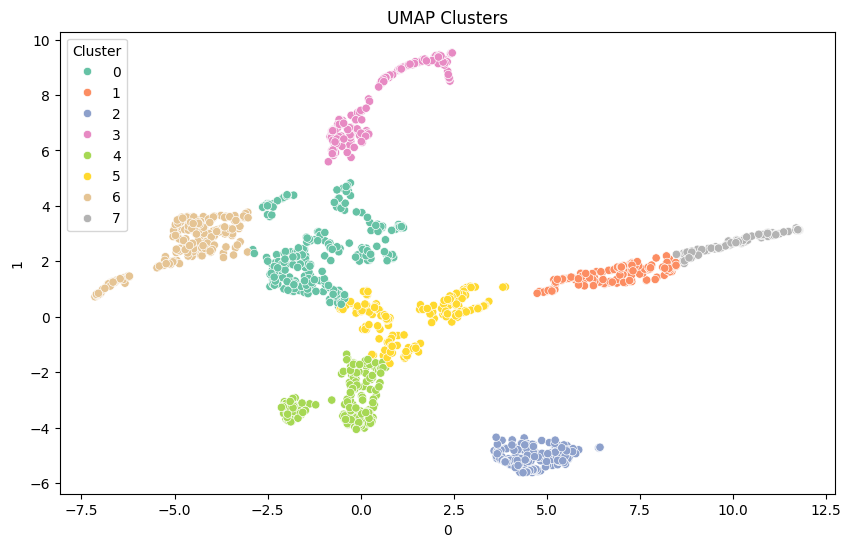

In [47]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'embedding_pred_df' is your DataFrame with UMAP coordinates and 'Cohort' information
X = embedding_pred_df[[0,1]]  # UMAP coordinates

# Apply KMeans clustering
kmeans = KMeans(n_clusters=8)  # Adjust the number of clusters as needed
embedding_pred_df['Cluster'] = kmeans.fit_predict(X)

# Plot UMAP with clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=0, y=1, hue='Cluster', data=embedding_pred_df, palette='Set2', legend='full')
plt.title('UMAP Clusters')
plt.show()


In [48]:
cluster_counts = embedding_pred_df.groupby(['Cluster', 'Cohort']).size().unstack(fill_value=0)
cluster_counts

Cohort   CRC  DLBCL  DLBCL+  Glioma  HELA  Melanoma  OSCC  PDAC  healthy LN  \
Cluster                                                                       
0         39     15       8       0     0        46    27   129          10   
1          0      0       0     124     0         6     0     0           0   
2          5      0       0       0   167         6     0     1           0   
3          1      7       0       0     0         6   140     2           6   
4          0    125      49       0     0        10     0     0           4   
5          6      6       2      31     0       104     0     6           0   
6         94     35      17       0     0        14     2    66           0   
7          0      1       0      91     0         0     0     0           0   

Cohort   healthy OE  
Cluster              
0                 0  
1                 0  
2                 0  
3                18  
4                 0  
5                 0  
6                 0  
7                 0

In [49]:
embedding_pred_df['Brain_metastasis'] = embedding_pred_df['ID'].isin(brain_mel_samples)

In [50]:
embedding_pred_df[(embedding_pred_df['Cluster'] == 6)&(embedding_pred_df['Cohort'] == 'Melanoma')]['Brain_metastasis'].value_counts()

Brain_metastasis
False    14
Name: count, dtype: int64

# We made four subpopulations: a glioblastoma, a known metastasis, a possible metastasis and a melanoma sample. 
Glioblastoma – known metastasis – possible metastasis - melanoma


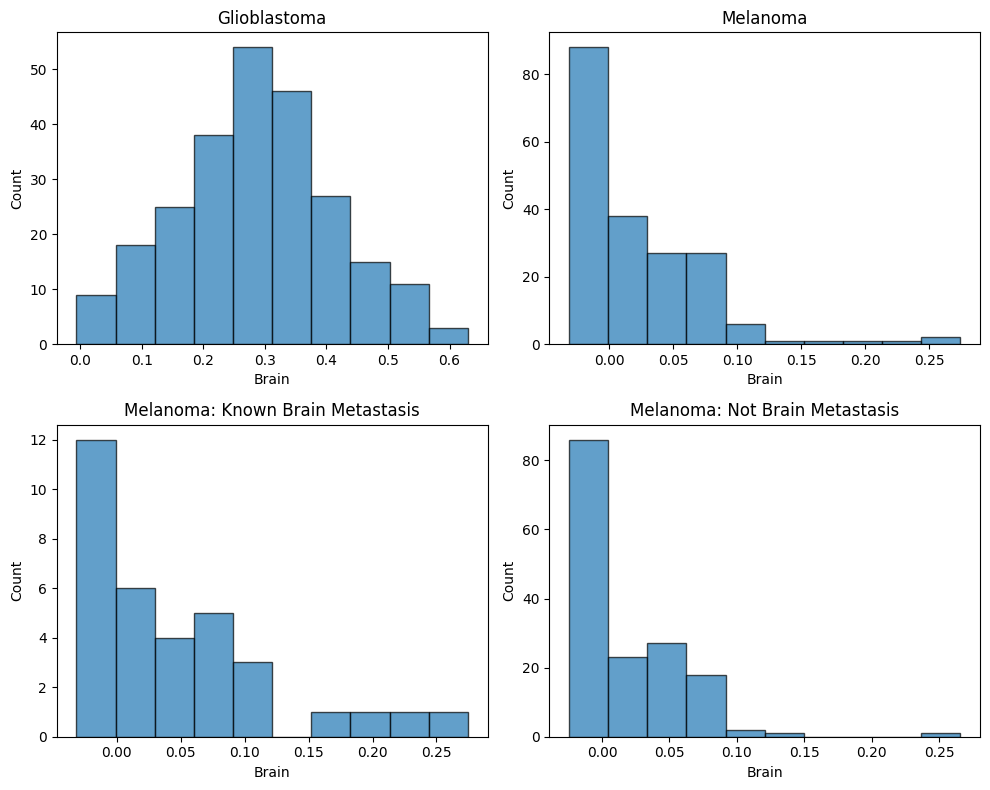

In [51]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].hist(prediction_mapping[prediction_mapping['Cohort'] == 'Glioma']['Brain'], color=sns.color_palette()[0], edgecolor='black', alpha=0.7)
axs[0, 0].set_title('Glioblastoma')
axs[0, 0].set_xlabel('Brain')
axs[0, 0].set_ylabel('Count')

axs[0, 1].hist(prediction_mapping[prediction_mapping['Cohort'] == 'Melanoma']['Brain'], color=sns.color_palette()[0], edgecolor='black', alpha=0.7)
axs[0, 1].set_title('Melanoma')
axs[0, 1].set_xlabel('Brain')
axs[0, 1].set_ylabel('Count')

axs[1, 0].hist(prediction_mapping[(prediction_mapping['Cancer_type'] == 'melanoma') & (prediction_mapping['Brain_metastasis'] == True)]['Brain'], color=sns.color_palette()[0], edgecolor='black', alpha=0.7)
axs[1, 0].set_title('Melanoma: Known Brain Metastasis')
axs[1, 0].set_xlabel('Brain')
axs[1, 0].set_ylabel('Count')

axs[1, 1].hist(prediction_mapping[(prediction_mapping['Cancer_type'] == 'melanoma') & (prediction_mapping['Brain_metastasis'] == False)]['Brain'], color=sns.color_palette()[0], edgecolor='black', alpha=0.7)
axs[1, 1].set_title('Melanoma: Not Brain Metastasis')
axs[1, 1].set_xlabel('Brain')
axs[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



ValueError: could not convert string to float: 'P056472_1'

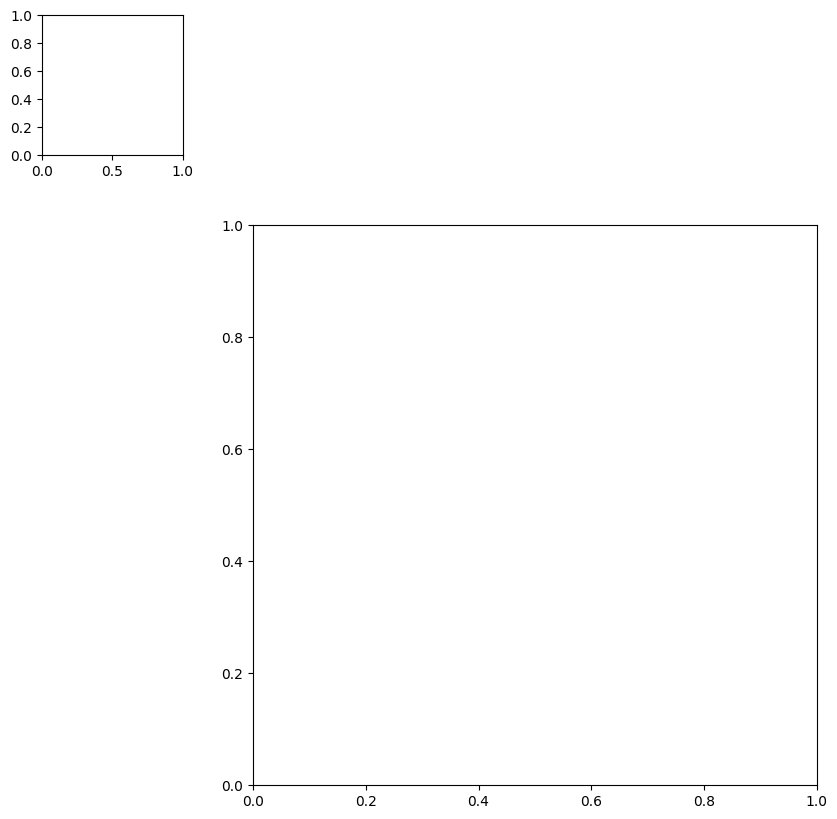

In [52]:
#so what other tissues then?

sns.clustermap(prediction_mapping[prediction_mapping['Cohort'].isin(['Glioma', 'Melanoma'])].set_index(['Cohort', 'Brain_metastasis']).iloc[:,1:-9], cmap='viridis', figsize=(10,10))

In [72]:
glioma_high_brain = prediction_mapping[(prediction_mapping['Cohort'] == 'Glioma') & (prediction_mapping['Brain'] > 0.4)].sort_values(by='Brain')['index'].values
glioma_low_brain = prediction_mapping[(prediction_mapping['Cohort'] == 'Glioma') & (prediction_mapping['Brain'] < 0.4)].sort_values(by='Brain')['index'].values

melanoma_meta_high_brain = prediction_mapping[(prediction_mapping['Cohort'] == 'Melanoma') &(prediction_mapping['Brain_metastasis'] == True) & (prediction_mapping['Brain'] > 0.15)].sort_values(by='Brain')['index'].values
melanoma_meta_low_brain = prediction_mapping[(prediction_mapping['Cohort'] == 'Melanoma') &(prediction_mapping['Brain_metastasis'] == True) & (prediction_mapping['Brain'] < 0.15)].sort_values(by='Brain')['index'].values

melanoma_notmeta_high_brain = prediction_mapping[(prediction_mapping['Cohort'] == 'Melanoma') &(prediction_mapping['Brain_metastasis'] == False) & (prediction_mapping['Brain'] > 0.15)].sort_values(by='Brain')['index'].values
melanoma_notmeta_low_brain = prediction_mapping[(prediction_mapping['Cohort'] == 'Melanoma') &(prediction_mapping['Brain_metastasis'] == False) & (prediction_mapping['Brain'] < 0.15)].sort_values(by='Brain')['index'].values

In [60]:
c = glioma_high_brain[0]

In [87]:
from collections import Counter
from itertools import chain
from tqdm import tqdm

all_common_proteins = {}

# Define the list of datasets and their corresponding names
datasets = [glioma_high_brain, glioma_low_brain, melanoma_meta_high_brain, melanoma_meta_low_brain, melanoma_notmeta_high_brain, melanoma_notmeta_low_brain]
dataset_names = [ "melanoma_notmeta_high_brain", "glioma_high_brain", "glioma_low_brain", "melanoma_meta_high_brain", "melanoma_meta_low_brain", "melanoma_notmeta_low_brain"]

# Iterate over the datasets with a progress bar
for l, name in tqdm(zip(datasets, dataset_names), desc="Processing datasets", total=len(datasets)):
    l_proteins = []
    common_proteins = []
    for c in l:
        tissue_to_study = "Brain"
        model = mlmarker.MLMarker(binary=False, dev=True, penalty_factor=1)
        subset = filtered_df[["Protein ID", c]]
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        subset[c] = scaler.fit_transform(subset[[c]])
        subset_pv = subset.pivot_table(columns='Protein ID', values=c)
        subset_pv = subset_pv.loc[:, (subset_pv != 0).any(axis=0)]
        model.load_sample(subset_pv.iloc[0:1, :])
        prediction = model.explainability.adjusted_absent_shap_values_df(n_preds=100)
        top_1_percent = prediction.loc[tissue_to_study][prediction.loc[tissue_to_study] > 0]
        l_proteins.append(top_1_percent.index.tolist())
    # Flatten the nested lists
    flat_list = list(chain(*l_proteins))
    # Count the occurrences of each protein
    protein_counts = Counter(flat_list)
    # Get the proteins that appear in at least 50% of the lists
    common_proteins = {protein: count for protein, count in protein_counts.items() if count >= len(l_proteins) / 2}
    if len(common_proteins) == 0:
        print(f'{name} has no common proteins.')
    all_common_proteins[name] = common_proteins


Processing datasets:   0%|          | 0/6 [00:00<?, ?it/s]

Processing datasets: 100%|██████████| 6/6 [08:27<00:00, 84.65s/it] 


In [88]:
for k,v in all_common_proteins.items():
    print(k, len(v))

melanoma_notmeta_high_brain 511
glioma_high_brain 403
glioma_low_brain 424
melanoma_meta_high_brain 209
melanoma_meta_low_brain 401
melanoma_notmeta_low_brain 184


In [ ]:
for k,v in all_common_proteins.items():
    print(k, len(v))

glioma_high_brain 57
glioma_low_brain 107
melanoma_meta_high_brain 0
melanoma_meta_low_brain 31
melanoma_notmeta_high_brain 0
melanoma_notmeta_low_brain 93


melanoma_notmeta_high_brain
glioma_high_brain
melanoma_meta_high_brain


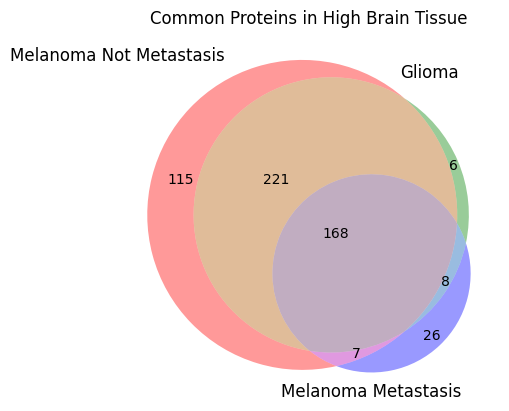

In [101]:
highs = ["melanoma_notmeta_high_brain", "glioma_high_brain", "melanoma_meta_high_brain"]
melanoma_notmeta_high_brain_upset, glioma_high_brain_upset, melanoma_meta_high_brain_upset =[], [], []
for sample, upsets in zip(highs, [melanoma_notmeta_high_brain, glioma_high_brain, melanoma_meta_high_brain]):
    print(sample)
    upset_list = list(all_common_proteins[sample].keys())
    if sample == "melanoma_notmeta_high_brain":
        melanoma_notmeta_high_brain_upset = upset_list
    elif sample == "glioma_high_brain":
        glioma_high_brain_upset = upset_list
    elif sample == "melanoma_meta_high_brain":
        melanoma_meta_high_brain_upset = upset_list
#make a venn diagram of three lists melanoma_notmeta_high_brain_upset, glioma_high_brain_upset, melanoma_meta_high_brain_upset
from matplotlib_venn import venn3
venn3([set(melanoma_notmeta_high_brain_upset), set(glioma_high_brain_upset), set(melanoma_meta_high_brain_upset)],
        set_labels=('Melanoma Not Metastasis', 'Glioma', 'Melanoma Metastasis'))
plt.title('Common Proteins in High Brain Tissue')
plt.show()


In [108]:
mlmarker.explainability.get_go_enrichment(melanoma_notmeta_high_brain_upset)

KeyError: 'p_value'

melanoma_notmeta_low_brain
glioma_low_brain
melanoma_meta_low_brain


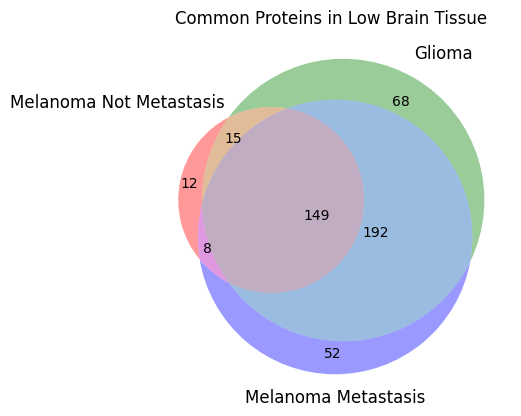

In [100]:
lows = ["melanoma_notmeta_low_brain", "glioma_low_brain", "melanoma_meta_low_brain"]
melanoma_notmeta_low_brain_upset, glioma_low_brain_upset, melanoma_meta_low_brain_upset =[], [], []
for sample, upsets in zip(lows, [melanoma_notmeta_low_brain, glioma_low_brain, melanoma_meta_low_brain]):
    print(sample)
    upset_list = list(all_common_proteins[sample].keys())
    if sample == "melanoma_notmeta_low_brain":
        melanoma_notmeta_low_brain_upset = upset_list
    elif sample == "glioma_low_brain":
        glioma_low_brain_upset = upset_list
    elif sample == "melanoma_meta_low_brain":
        melanoma_meta_low_brain_upset = upset_list
#make a venn diagram of three lists melanoma_notmeta_low_brain_upset, glioma_low_brain_upset, melanoma_meta_low_brain_upset
from matplotlib_venn import venn3
venn3([set(melanoma_notmeta_low_brain_upset), set(glioma_low_brain_upset), set(melanoma_meta_low_brain_upset)],
        set_labels=('Melanoma Not Metastasis', 'Glioma', 'Melanoma Metastasis'))
plt.title('Common Proteins in Low Brain Tissue')
plt.show()


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/upsetplot/plotting.py:795: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/upsetplot/plotting.py:796: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

<Figure size 1000x600 with 0 Axes>

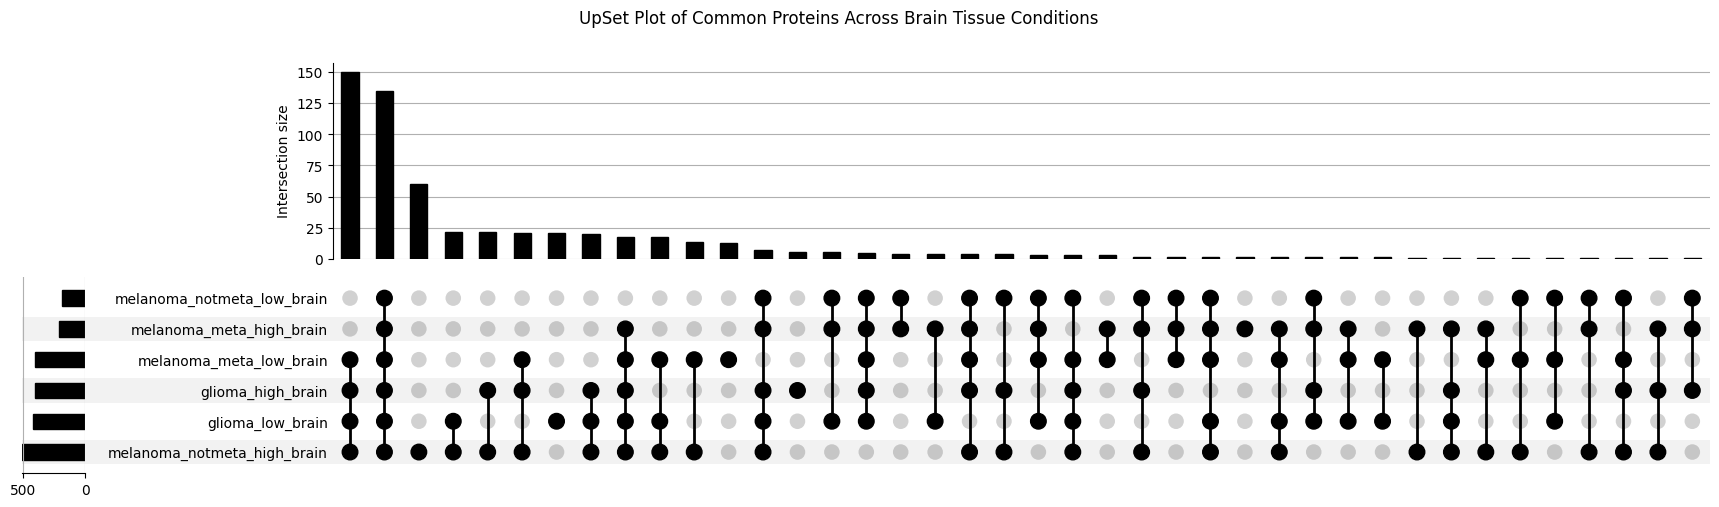

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
from upsetplot import UpSet, from_indicators

# Define the sample groups
samples = [
    "melanoma_notmeta_high_brain", "glioma_high_brain", "melanoma_meta_high_brain",
    "melanoma_notmeta_low_brain", "glioma_low_brain", "melanoma_meta_low_brain"
]

# Collect all unique proteins across the six groups
all_proteins = set()
for sample in samples:
    all_proteins.update(all_common_proteins[sample].keys())

# Create a DataFrame for UpSet plot
data_dict = {protein: {sample: protein in all_common_proteins[sample] for sample in samples} for protein in all_proteins}
df = pd.DataFrame.from_dict(data_dict, orient="index")

# Convert boolean values to integers for UpSet plot compatibility
df = df.astype(bool)
# Create the UpSet plot
plt.figure(figsize=(10, 6))
upset = UpSet(from_indicators(samples, df), sort_by="cardinality")
upset.plot()
plt.suptitle("UpSet Plot of Common Proteins Across Brain Tissue Conditions")
plt.show()


melanoma_notmeta_high_brain  glioma_high_brain  \
Q9NUB1                            1                  1   
Q92545                            1                  1   
O15075                            1                  1   
Q8WXF7                            1                  1   
Q9UBR1                            1                  0   
...                             ...                ...   
Q9ULC4                            0                  1   
O43815                            1                  0   
P01703                            1                  1   
Q15843                            0                  0   
Q52LJ0                            1                  0   

        melanoma_meta_high_brain  melanoma_notmeta_low_brain  \
Q9NUB1                         0                           0   
Q92545                         0                           0   
O15075                         1                           1   
Q8WXF7                         0                           0   
Q9UBR1                         0                           0   
...                          ...                         ...   
Q9ULC4                         1                           1   
O43815                         0                           0   
P01703                         0                           0   
Q15843                         0                           0   
Q52LJ0                         0                           0   

        glioma_low_brain  melanoma_meta_low_brain  
Q9NUB1                 0                        1  
Q92545                 0                        1  
O15075                 1                        1  
Q8WXF7                 0                        1  
Q9UBR1                 0                        0  
...                  ...                      ...  
Q9ULC4                 0                        0  
O43815                 1                        1  
P01703                 1                        1  
Q15843                 1                        0  
Q52LJ0                 0                        0  

[588 rows x 6 columns]

In [145]:
from mlmarker import visualise_custom_plot
from mlmarker import visualise_custom_tissue_plot
from mlmarker.explainability import get_protein_info
import requests
from io import StringIO
def get_hpa_info(protein_id):
    url = f"https://www.proteinatlas.org/api/search_download.php?search={protein_id}&format=tsv&columns=up,rnatsm,rnabcs,rnabcd,rnabcss,rnabcsm,rnabls,rnabld,rnablss,rnablsmecblood,ectissue,blconcms&compress=no"
    response = requests.get(url)
    df = pd.read_csv(StringIO(response.text), sep='\t')
    return df

tissue_to_study="Brain"
model = mlmarker.MLMarker(binary=False, dev=True, penalty_factor=1)



subset = filtered_df[["Protein ID", c]]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
subset[c] = scaler.fit_transform(subset[[c]])
subset_pv = subset.pivot_table(columns='Protein ID', values = c)
subset_pv = subset_pv.loc[:, (subset_pv != 0).any(axis=0)]
model.load_sample(subset_pv.iloc[0:1, :])
prediction = model.explainability.adjusted_absent_shap_values_df(n_preds=100)

pd.set_option('display.max_colwidth', None)
visualise_custom_plot(prediction)
visualise_custom_tissue_plot(prediction, tissue_name=tissue_to_study, show_others=False, threshold_others = 0.001) 
top10_cont = prediction.loc[tissue_to_study].sort_values().tail(10).index.tolist()
top10_info_cont = []
top10_hpa_cont = []
for i in top10_cont:
    print(i)
    top10_info_cont.append(get_protein_info(i))
    top10_hpa_cont.append(get_hpa_info(i))
pd.DataFrame(top10_info_cont)
shaps = pd.DataFrame(prediction.loc[tissue_to_study][top10_cont].reset_index())
shaps.rename(columns={tissue_to_study: 'value'}, inplace=True)

# Assuming top10_hpa_notcont is a list of DataFrames
combined_hpa_df = pd.concat(top10_hpa_cont, ignore_index=True)
combined_hpa_df = combined_hpa_df[['Uniprot', 'RNA tissue specific nTPM', 'Tissue expression cluster']]
combined_hpa_df = pd.merge(combined_hpa_df, pd.DataFrame(top10_info_cont), left_on='Uniprot', right_on='id')
combined_hpa_df = pd.merge(combined_hpa_df, shaps, left_on='Uniprot', right_on='index')
combined_hpa_df.drop(columns=['id', 'index'], inplace=True)
combined_hpa_df.sort_values(by='value', ascending=False)
combined_hpa_df.head()



Q14CZ8
Q16620
Q9UPA5
O14807
P31323
Q96GW7
Q86UW8
P62760
Q14515
P26992
Q99962
Q92777
O94811
Q92752
P60201
P38606
P07196
P20916
P09543
Q9NQC3


Uniprot                      RNA tissue specific nTPM  \
0  Q14CZ8  adipose tissue: 15.2;brain: 52.3;liver: 15.5   
1  Q16620             brain: 241.7;thyroid gland: 122.2   
2  Q9UPA5                                   brain: 30.0   
3  O14807              brain: 132.9;heart muscle: 128.5   
4  P31323                         adipose tissue: 164.0   

                          Tissue expression cluster   entry name  \
0            Cluster 33: Brain - Neuronal signaling  HECAM_HUMAN   
1            Cluster 33: Brain - Neuronal signaling  NTRK2_HUMAN   
2  Cluster 22: Brain - Synaptic signal transduction    BSN_HUMAN   
3      Cluster 30: Heart muscle - Heart development   RASM_HUMAN   
4        Cluster 7: Adipose tissue - Mixed function   KAP3_HUMAN   

                                                                                                                                                               protein_names  \
0                                                                  Hepatic and glial cell adhesion molecule (glialCAM) (Hepatocyte cell adhesion molecule) (Protein hepaCAM)   
1  BDNF/NT-3 growth factors receptor (EC 2.7.10.1) (GP145-TrkB) (Trk-B) (Neurotrophic tyrosine kinase receptor type 2) (TrkB tyrosine kinase) (Tropomyosin-related kinase B)   
2                                                                                                                                  Protein bassoon (Zinc finger protein 231)   
3                                                                                                        Ras-related protein M-Ras (EC 3.6.5.2) (Ras-related protein R-Ras3)   
4                                                                                                              cAMP-dependent protein kinase type II-beta regulatory subunit   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             tissue_specificity  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           NaN   
1  TISSUE SPECIFICITY: Isoform TrkB is expressed in the central and peripheral nervous system. In the central nervous system (CNS), expression is observed in the cerebral cortex, hippocampus, thalamus, choroid plexus, granular layer of the cerebellum, brain stem, and spinal cord. In the peripheral nervous system, it is expressed in many cranial ganglia, the ophthalmic nerve, the vestibular system, multiple facial structures, the submaxillary glands, and dorsal root ganglia. Isoform TrkB-T1 is mainly expressed in the brain but also detected in other tissues including pancreas, kidney and heart. Isoform TrkB-T-Shc is predominantly expressed in the brain. {ECO:0000269|PubMed:11798182, ECO:0000269|PubMed:7936202}.   
2           